<a href="https://colab.research.google.com/github/RemyaVKarthikeyan/AA-Stagecoach-Project/blob/main/Random_Forest_SWT%2CAWT%2CEWT_calculation_(27_07_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

27/07/2024

In [ ]:
!pip install pandas openpyxl

In [ ]:
import pandas as pd
import requests
from difflib import SequenceMatcher

# Function to normalize stop names
def normalize_stop_name(name):
    return ' '.join(name.lower().split())

from google.colab import drive
drive.mount('/content/drive')

# Modify this path accordingly
file_path = '/content/drive/MyDrive/QSI points.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Get the lineID from the user
lineID = input("Please enter the lineID: ")

# Check if the necessary column is present
if 'Route_Dir_QSI_No' not in df.columns:
    print("The 'Route_Dir_QSI_No' column is not present in the provided file.")
else:
    # Convert the lineID to uppercase to ensure case-insensitivity
    lineID = lineID.upper()

    # Convert the 'Route_Dir_QSI_No' column to uppercase for comparison
    df['Route_Dir_QSI_No'] = df['Route_Dir_QSI_No'].str.upper()

    # Normalize the stop names in the DataFrame
    df['STOP_NAME'] = df['STOP_NAME'].apply(normalize_stop_name)

    # Create regular expressions for filtering
    pattern_A = f"^{lineID}_A\\d+$"  # Regular expression for lineID_A**
    pattern_B = f"^{lineID}_B\\d+$"  # Regular expression for lineID_B**

    # Filter rows where the 'Route_Dir_QSI_No' column matches the pattern
    filtered_df_A = df[df['Route_Dir_QSI_No'].str.match(pattern_A, na=False)][['Route_Dir_QSI_No', 'STOP_NAME']]
    filtered_df_B = df[df['Route_Dir_QSI_No'].str.match(pattern_B, na=False)][['Route_Dir_QSI_No', 'STOP_NAME']]

    # Function to fetch and process route sequence data from TfL API
    def fetch_and_process_route_data(route_type, pattern, filtered_df):
        api_url = f"https://api.tfl.gov.uk/Line/{lineID}/Route/Sequence/{route_type}"
        response = requests.get(api_url)

        results_list = []

        if response.status_code == 200:
            route_data = response.json()

            # Iterate through each stop in the route data
            for stop in route_data['stopPointSequences'][0]['stopPoint']:
                stop_name_api = normalize_stop_name(stop['name'])
                stop_id = stop['id']

                # Check if the stop_name_api exists in the filtered DataFrame for the correct direction
                matched_row = filtered_df[(filtered_df['STOP_NAME'] == stop_name_api) &
                                          (filtered_df['Route_Dir_QSI_No'].str.match(pattern))]

                if not matched_row.empty:
                    route_dir_qsi_no = matched_row.iloc[0]['Route_Dir_QSI_No']
                    results_list.append({
                        'Route_Dir_QSI_No': route_dir_qsi_no,
                        'STOP_Name': stop['name'],
                        'ID': stop_id
                    })
                else:
                    # If exact match not found, try partial matching based on words before and after '/'
                    api_stop_name_parts = stop_name_api.split('/')
                    for index, row in filtered_df.iterrows():
                        df_stop_name_parts = row['STOP_NAME'].split('/')
                        for api_part in api_stop_name_parts:
                            for df_part in df_stop_name_parts:
                                if SequenceMatcher(None, df_part.strip(), api_part.strip()).ratio() > 0.8:
                                    matched_row = pd.DataFrame([row])
                                    break
                            if not matched_row.empty:
                                break
                        if not matched_row.empty:
                            break

                    if not matched_row.empty:
                        route_dir_qsi_no = matched_row.iloc[0]['Route_Dir_QSI_No']
                        results_list.append({
                            'Route_Dir_QSI_No': route_dir_qsi_no,
                            'STOP_Name': stop['name'],
                            'ID': stop_id
                        })
        else:
            print(f"Failed to fetch route sequence data from TfL API for {route_type} route. Status code: {response.status_code}")

        return results_list

    # Fetch and process outbound route data for _A**
    matched_results_A = fetch_and_process_route_data('outbound', pattern_A, filtered_df_A)

    # Fetch and process inbound route data for _B**
    matched_results_B = fetch_and_process_route_data('inbound', pattern_B, filtered_df_B)

    # Create DataFrames from the matched results for each direction
    matched_results_df_A = pd.DataFrame(matched_results_A)
    matched_results_df_B = pd.DataFrame(matched_results_B)

    # Function to remove partial matches if exact matches are found
    def remove_partial_matches(exact_df, matched_df):
        for index, row in exact_df.iterrows():
            exact_stop_name = row['STOP_NAME']
            route_dir_qsi_no = row['Route_Dir_QSI_No']
            # Find exact matches in matched_df
            exact_matches = matched_df[(matched_df['Route_Dir_QSI_No'] == route_dir_qsi_no) &
                                       (matched_df['STOP_Name'].apply(normalize_stop_name) == exact_stop_name)]
            if not exact_matches.empty:
                # Remove partial matches
                matched_df = matched_df[~((matched_df['Route_Dir_QSI_No'] == route_dir_qsi_no) &
                                          (matched_df['STOP_Name'].apply(normalize_stop_name) != exact_stop_name))]
        return matched_df

    # Remove partial matches for direction A
    matched_results_df_A = remove_partial_matches(filtered_df_A, matched_results_df_A)

    # Remove partial matches for direction B
    matched_results_df_B = remove_partial_matches(filtered_df_B, matched_results_df_B)

    # Remove duplicate stop names with the same Route_Dir_QSI_No and different IDs
    matched_results_df_A = matched_results_df_A.drop_duplicates(subset=['Route_Dir_QSI_No', 'STOP_Name'], keep='first')
    matched_results_df_B = matched_results_df_B.drop_duplicates(subset=['Route_Dir_QSI_No', 'STOP_Name'], keep='first')

    # Print the matched results for direction A
    print(f"\n\n\033[1m\033[4mQSI stop points for direction {lineID}_A\033[0m\n")
    matched_results_df_A = matched_results_df_A[matched_results_df_A['Route_Dir_QSI_No'].str.match(pattern_A)]
    print(matched_results_df_A[['Route_Dir_QSI_No', 'STOP_Name', 'ID']])

    # Print the matched results for direction B
    print(f"\n\n\033[1m\033[4mQSI stop points for direction {lineID}_B\033[0m\n")
    matched_results_df_B = matched_results_df_B[matched_results_df_B['Route_Dir_QSI_No'].str.match(pattern_B)]
    print(matched_results_df_B[['Route_Dir_QSI_No', 'STOP_Name', 'ID']])

    # Concatenate the matched results DataFrames for directions A and B
    combined_df = pd.concat([matched_results_df_A, matched_results_df_B], ignore_index=True)

    # Display the combined DataFrame
    print("\n\n\033[1m\033[4mCombined QSI stop points for directions A and B\033[0m\n")
    print(combined_df[['Route_Dir_QSI_No', 'STOP_Name', 'ID']])


Mounted at /content/drive
Please enter the lineID: d7


QSI stop points for direction D7_A

  Route_Dir_QSI_No                    STOP_Name          ID
0            D7_A1   Poplar / All Saints Church  490011107G
1            D7_A2               Stewart Street  490013513S
2            D7_A3       Island Gardens Station  490002048Z
3            D7_A4  Arnhem Wharf Primary School  490006092N
5            D7_A5         East India Dock Road  490004584N


QSI stop points for direction D7_B

  Route_Dir_QSI_No                    STOP_Name          ID
0            D7_B1  Mile End Station / Bow Road  490015151H
2            D7_B2         East India Dock Road  490004584S
3            D7_B3         Canary Wharf Station  490000038F
5            D7_B4  Arnhem Wharf Primary School  490006092S
6            D7_B5       Island Gardens Station  490002048X
7            D7_B6               Stewart Street  490013513N


Combined QSI stop points for directions A and B

   Route_Dir_QSI_No                    

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import pytz
import time
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Function to fetch arrival predictions
def fetch_arrival_predictions(line_id, stop_point_id, direction):
    try:
        base_url = f"https://api.tfl.gov.uk/Line/{line_id}/Arrivals/{stop_point_id}"
        params = {'direction': direction}
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        if len(data) == 0:
            return pd.DataFrame(), None  # No data available
        station_name = data[0]['stationName']
        predictions = []
        for item in data:
            arrival_time = datetime.strptime(item['expectedArrival'], '%Y-%m-%dT%H:%M:%SZ')
            arrival_time_bst = arrival_time + timedelta(hours=1)
            predictions.append({
                'Line': item['lineName'],
                'Vehicle ID': item['vehicleId'],
                'Stop Point': stop_point_id,
                'Direction': direction,
                'Expected Arrival (BST)': arrival_time_bst,
                'Expected Arrival (HM)': arrival_time_bst.strftime('%H:%M')
            })
        df = pd.DataFrame(predictions)
        df = df.sort_values(by='Expected Arrival (BST)', ascending=True)
        df['Expected Arrival (BST)'] = pd.to_datetime(df['Expected Arrival (BST)'])  # Convert to datetime
        df['Expected Arrival (HM)'] = pd.to_datetime(df['Expected Arrival (HM)'], format='%H:%M')
        df['Gap'] = df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
        df['2_Gap'] = (df['Gap'] * 2).round(2)
        df['Gap_Sq'] = (df['Gap'] * df['Gap']).round(2)
        return df, station_name
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None, None

def main():
    # Assuming combined_df is generated from the previous cell
    # combined_df should have columns like 'Route_Dir_QSI_No', 'STOP_Name', 'ID'
    import pandas as pd
    import requests
    from datetime import datetime
    import pytz

    # Function to normalize stop names
    def normalize_stop_name(name):
        return ' '.join(name.lower().split())

    # Function to fetch data from the API
    def fetch_data(url):
        response = requests.get(url)
        return response.json()

    # Function to extract schedule names
    def extract_schedule_names(data, schedule_names_dict={}):
        if isinstance(data, dict):
            if data.get('$type') == "Tfl.Api.Presentation.Entities.Schedule, Tfl.Api.Presentation.Entities" and 'knownJourneys' in data:
                if 'name' in data:
                    schedule_names_dict[data['name']] = data['knownJourneys']
            for key, value in data.items():
                extract_schedule_names(value, schedule_names_dict)
        elif isinstance(data, list):
            for item in data:
                extract_schedule_names(item, schedule_names_dict)
        return schedule_names_dict

    # Function to categorize journeys into hourly slots
    def categorize_into_slots(timetable):
        slots = [[] for _ in range(24)]
        for journey in timetable:
            hour = int(journey['hour'])  # Convert hour to integer
            if 0 <= hour < 24:  # Ensure hour is within the valid range
                slots[hour].append(journey)
        return slots

    # Function to fetch the current day of the week
    def get_day_of_week():
        bst = pytz.timezone('Europe/London')
        now = datetime.now(bst)
        return now.strftime('%A')  # %A gives full weekday name (e.g., 'Monday')

    # Function to calculate Scheduled Wait Time (SWT) for all hours
    def calculate_swt_for_all_hours(slots):
        swt_per_hour = []
        for hour in range(24):
            total_buses = len(slots[hour])
            scheduled_wait_time = 60 / (total_buses * 2) if total_buses > 0 else None  # Use None to indicate no buses
            swt_per_hour.append((scheduled_wait_time, total_buses))
        return swt_per_hour

    # Function to select the preferred schedule name based on the current day of the week
    def select_preferred_schedule(schedule_names_dict, day_of_week):
        if day_of_week.lower() in ['monday', 'tuesday', 'wednesday', 'thursday']:
            preferred_schedule_names = ['Mon-Fri Schooldays', 'Monday to Thursday', 'Monday to Friday']
        elif day_of_week.lower() == 'friday':
            preferred_schedule_names = ['Mon-Fri Schooldays', 'Monday to Friday', 'Friday']
        elif day_of_week.lower() == 'saturday':
            preferred_schedule_names = ['Saturday']
        elif day_of_week.lower() == 'sunday':
            preferred_schedule_names = ['Sunday']
        else:
            preferred_schedule_names = [day_of_week]

        for preferred_name in preferred_schedule_names:
            if preferred_name in schedule_names_dict:
                return preferred_name
        return None

    # Main logic to fetch and calculate SWT
    def main(combined_df, lineID):
        bst = pytz.timezone('Europe/London')
        swt_data = {
            'Route_Dir_QSI_No': [],
            'ID': [],
        }
        # Initialize keys for all 24 hours in the dictionary
        for hour in range(24):
            swt_data[f'SWT_{hour}'] = []
            swt_data[f'Sch_{hour}'] = []

        # Update current time and hour
        current_time = datetime.now(bst)
        day_of_week = get_day_of_week()

        # Store selected schedule name to ensure it's printed only once
        selected_schedule_name = None
        printed_schedule_name = False

        for index, row in combined_df.iterrows():
            stop_point_id = row['ID']
            route_dir_qsi_no = row['Route_Dir_QSI_No']

            if f"{lineID}_A" in route_dir_qsi_no:
                direction = 'outbound'
            elif f"{lineID}_B" in route_dir_qsi_no:
                direction = 'inbound'
            else:
                continue

            url = f'https://api.tfl.gov.uk/Line/{lineID}/Timetable/{stop_point_id}?direction={direction}'
            data = fetch_data(url)

            schedule_names_dict = extract_schedule_names(data)

            if not selected_schedule_name:
                selected_schedule_name = select_preferred_schedule(schedule_names_dict, day_of_week)

            if selected_schedule_name and not printed_schedule_name:
                print(f"\n\033[1m\033[4mToday is {day_of_week}. The selected Schedule name is {selected_schedule_name}.\033[0m")
                printed_schedule_name = True

            if selected_schedule_name:
                timetable = schedule_names_dict[selected_schedule_name]
                slots = categorize_into_slots(timetable)

                # Calculate SWT for all hours
                swt_per_hour = calculate_swt_for_all_hours(slots)

                # Store SWT data for all hours
                swt_data['Route_Dir_QSI_No'].append(route_dir_qsi_no)
                swt_data['ID'].append(stop_point_id)
                for hour in range(24):
                    swt, total_buses = swt_per_hour[hour]
                    swt_data[f'SWT_{hour}'].append(swt)
                    swt_data[f'Sch_{hour}'].append(total_buses)

        # Create DataFrame for SWT data
        swt_df = pd.DataFrame(swt_data)

        # Calculate Route SWT for each hour for directions A and B
        route_swt_data = {
            'Hour': [],
            'Route SWT A': [],
            'Route SWT B': []
        }

        for hour in range(24):
            # Calculate Route SWT for direction A
            swt_a = swt_df[swt_df['Route_Dir_QSI_No'].str.contains(f'{lineID}_A')]
            valid_swt_a = swt_a[pd.notna(swt_a[f'SWT_{hour}'])]  # Filter out NaN values
            weighted_sum_a = sum(valid_swt_a[f'SWT_{hour}'] * valid_swt_a[f'Sch_{hour}']) if not valid_swt_a.empty else 0
            total_buses_a = sum(valid_swt_a[f'Sch_{hour}']) if not valid_swt_a.empty else 0
            route_swt_a = round(weighted_sum_a / total_buses_a, 2) if total_buses_a > 0 else None


            # Calculate Route SWT for direction B
            swt_b = swt_df[swt_df['Route_Dir_QSI_No'].str.contains(f'{lineID}_B')]
            valid_swt_b = swt_b[pd.notna(swt_b[f'SWT_{hour}'])]  # Filter out NaN values
            weighted_sum_b = sum(valid_swt_b[f'SWT_{hour}'] * valid_swt_b[f'Sch_{hour}']) if not valid_swt_b.empty else 0
            total_buses_b = sum(valid_swt_b[f'Sch_{hour}']) if not valid_swt_b.empty else 0
            route_swt_b = round(weighted_sum_b / total_buses_b, 2) if total_buses_b > 0 else None

            route_swt_data['Hour'].append(hour)
            route_swt_data['Route SWT A'].append(route_swt_a)
            route_swt_data['Route SWT B'].append(route_swt_b)

        route_swt_df = pd.DataFrame(route_swt_data)
        return route_swt_df
        # Print the Route SWT DataFrame
        print("\n\nRoute SWT DataFrame:")
        print(route_swt_df.to_string())

    # Assuming combined_df and lineID are defined and available
    # combined_df = ... (from previous code)
    # lineID = ... (from user input)
    route_swt_df = main(combined_df, lineID)
    # Example dictionary to hold cumulative dataframes for each stop point
    cumulative_dataframes = {}

    # Dictionary to hold the number of buses observed per stop point
    buses_observed = {}

    # DataFrame to store Route AWT data
    route_awt_df = pd.DataFrame(columns=['Hour', 'Route AWT A', 'Route AWT B'])

    # Loop through unique stop points in combined_df
    for index, row in combined_df.iterrows():
        stop_point_id = row['ID']
        direction = 'outbound' if row['Route_Dir_QSI_No'].startswith(lineID + '_A') else 'inbound'

        cumulative_df = pd.DataFrame(columns=[
            'Line', 'Vehicle ID', 'Stop Point', 'Direction',
            'Expected Arrival (BST)', 'Expected Arrival (HM)',
            'Gap', '2_Gap', 'Gap_Sq'
        ])

        cumulative_dataframes[stop_point_id] = cumulative_df  # Initialize cumulative dataframe
        buses_observed[stop_point_id] = (0, 0, 0, 0)  # Initialize with zero values

    while True:
        for stop_point_id, cumulative_df in cumulative_dataframes.items():
            direction = 'outbound' if combined_df[combined_df['ID'] == stop_point_id]['Route_Dir_QSI_No'].iloc[0].startswith(lineID + '_A') else 'inbound'

            arrival_predictions_df, station_name = fetch_arrival_predictions(lineID, stop_point_id, direction)

            if arrival_predictions_df is not None and not arrival_predictions_df.empty:
                current_hour = datetime.now(pytz.timezone('Europe/London')).hour

                for _, row in arrival_predictions_df.iterrows():
                    vehicle_id = row['Vehicle ID']

                    mask = cumulative_df['Vehicle ID'] == vehicle_id

                    if cumulative_df[mask].empty:
                        # If vehicle ID is not present in cumulative DataFrame, append the row
                        cumulative_df = pd.concat([cumulative_df, row.to_frame().T], ignore_index=True)
                    else:
                        # If vehicle ID is present, overwrite the row
                        cumulative_df.loc[mask, ['Line', 'Stop Point', 'Direction', 'Expected Arrival (BST)', 'Expected Arrival (HM)', 'Gap', '2_Gap', 'Gap_Sq']] = row[['Line', 'Stop Point', 'Direction', 'Expected Arrival (BST)', 'Expected Arrival (HM)', 'Gap', '2_Gap', 'Gap_Sq']].values

                # Convert to datetime
                cumulative_df['Expected Arrival (BST)'] = pd.to_datetime(cumulative_df['Expected Arrival (BST)'])
                cumulative_df['Expected Arrival (HM)'] = pd.to_datetime(cumulative_df['Expected Arrival (HM)'], format='%H:%M')

                # Sort the DataFrame
                cumulative_df = cumulative_df.sort_values(by='Expected Arrival (BST)', ascending=True).reset_index(drop=True)

                # Calculate gaps
                cumulative_df['Gap'] = (cumulative_df['Expected Arrival (BST)'].diff().dt.total_seconds() / 60).round(2)
                cumulative_df.loc[0, 'Gap'] = 0  # First row gap should be zero
                cumulative_df['2_Gap'] = (cumulative_df['Gap'] * 2).round(2)
                cumulative_df['Gap_Sq'] = (cumulative_df['Gap'] * cumulative_df['Gap']).round(2)

                # Update number of buses observed in the current hour
                num_buses_observed = len(cumulative_df[cumulative_df['Expected Arrival (BST)'].dt.hour == current_hour]['Vehicle ID'].unique())
                total_Gap_Sq = cumulative_df[cumulative_df['Expected Arrival (BST)'].dt.hour == current_hour]['Gap_Sq'].sum()
                total_2_Gap = cumulative_df[cumulative_df['Expected Arrival (BST)'].dt.hour == current_hour]['2_Gap'].sum()
                AWT = round(total_Gap_Sq / total_2_Gap, 2) if total_2_Gap > 0 else 0
                buses_observed[stop_point_id] = (num_buses_observed, total_Gap_Sq, total_2_Gap, AWT)

                print(f"\nArrival Predictions for stop point {stop_point_id} ({station_name}):")
                print(arrival_predictions_df.to_string(index=False))
                print("\nCumulative DataFrame:")
                print(cumulative_df.to_string(index=False))
                print(f"\nNumber of buses observed in the current hour: {num_buses_observed}")
            else:
                print("No arrival predictions available.")



            print("Refreshing data in 30 seconds...\n")
            time.sleep(30)

            # Update cumulative dataframe in dictionary
            cumulative_dataframes[stop_point_id] = cumulative_df

        print("\nRoute SWT DataFrame:")
        print(route_swt_df)

        # Create DataFrame to show number of buses observed for each stop point
        buses_observed_df = pd.DataFrame(list(buses_observed.items()), columns=['Stop Point', 'Metrics'])

        # Split 'Metrics' into separate columns
        buses_observed_df[['Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap', 'AWT']] = pd.DataFrame(
            buses_observed_df['Metrics'].tolist(), index=buses_observed_df.index
        )

        # Calculate WAWT as the product of AWT and Num of Buses Observed
        buses_observed_df['WAWT'] = buses_observed_df['AWT'] * buses_observed_df['Num of Buses Observed']

        # Drop the 'Metrics' column
        buses_observed_df.drop(columns=['Metrics'], inplace=True)

        print("\nNumber of Buses Observed DataFrame:")
        print(buses_observed_df)

        # Calculate Route AWT A and Route AWT B
        pattern_A = f"^{lineID}_A\\d+$"
        pattern_B = f"^{lineID}_B\\d+$"

        buses_observed_df_A = buses_observed_df[buses_observed_df['Stop Point'].isin(combined_df[combined_df['Route_Dir_QSI_No'].str.match(pattern_A)]['ID'])]
        buses_observed_df_B = buses_observed_df[buses_observed_df['Stop Point'].isin(combined_df[combined_df['Route_Dir_QSI_No'].str.match(pattern_B)]['ID'])]

        sum_WAWT_A = buses_observed_df_A['WAWT'].sum()
        sum_buses_observed_A = buses_observed_df_A['Num of Buses Observed'].sum()
        route_AWT_A = round(sum_WAWT_A / sum_buses_observed_A, 2) if sum_buses_observed_A > 0 else 0

        sum_WAWT_B = buses_observed_df_B['WAWT'].sum()
        sum_buses_observed_B = buses_observed_df_B['Num of Buses Observed'].sum()
        route_AWT_B = round(sum_WAWT_B / sum_buses_observed_B, 2) if sum_buses_observed_B > 0 else 0

        current_hour = datetime.now(pytz.timezone('Europe/London')).hour

        # Check if the current hour's data is already present
        if current_hour in route_awt_df['Hour'].values:
            route_awt_df.loc[route_awt_df['Hour'] == current_hour, ['Route AWT A', 'Route AWT B']] = [route_AWT_A, route_AWT_B]
        else:
            new_row = pd.DataFrame({
                'Hour': [current_hour],
                'Route AWT A': [route_AWT_A],
                'Route AWT B': [route_AWT_B]
            })
            route_awt_df = pd.concat([route_awt_df, new_row], ignore_index=True)

        #print("\nRoute SWT DataFrame:")
        #print(route_swt_df)

        print("\nRoute AWT DataFrame:")
        print(route_awt_df)
        route_ewt_df = pd.DataFrame(columns=['Hour', 'Route EWT A', 'Route EWT B'])
        current_hour = datetime.now(pytz.timezone('Europe/London')).hour
        route_ewt_df = pd.DataFrame([[current_hour, None, None]], columns=['Hour', 'Route EWT A','Route EWT B'])

        # Merge route_awt_df and route_swt_df on 'Hour'
        merged_df = pd.merge(route_awt_df, route_swt_df, on='Hour')
        print(merged_df)

        # Calculate the 'Route EWT A' and 'Route EWT B' columns
        merged_df['Route EWT A'] = merged_df['Route AWT A'] - merged_df['Route SWT A']
        merged_df['Route EWT B'] = merged_df['Route AWT B'] - merged_df['Route SWT B']

        # Update or insert the data for the current hour
        if current_hour in route_ewt_df['Hour'].values:
            route_ewt_df.loc[route_ewt_df['Hour'] == current_hour, ['Route EWT A', 'Route EWT B']] = [
                merged_df.loc[merged_df['Hour'] == current_hour, 'Route EWT A'].values[0],
                merged_df.loc[merged_df['Hour'] == current_hour, 'Route EWT B'].values[0]
            ]
        else:
            new_row = pd.DataFrame({
                'Hour': [current_hour],
                'Route EWT A': [merged_df.loc[merged_df['Hour'] == current_hour, 'Route EWT A'].values[0]],
                'Route EWT B': [merged_df.loc[merged_df['Hour'] == current_hour, 'Route EWT B'].values[0]]
            })
            route_ewt_df = pd.concat([route_ewt_df, new_row], ignore_index=True)

        # Keep only the desired columns
        route_ewt_df = route_ewt_df[['Hour', 'Route EWT A', 'Route EWT B']]

        print("\nRoute EWT DataFrame:")
        print(route_ewt_df)

        print("Predictions\n")

        # Function to simulate historical data (can be replaced with real historical data loading)
        def simulate_historical_data(current_value, num_points=10):
            np.random.seed(0)  # For reproducibility
            historical_data = [current_value + np.random.normal(0, 0.1) for _ in range(num_points)]
            return pd.Series(historical_data)

        # Function to prepare data for Random Forest
        def prepare_data_for_rf(historical_series):
            X = np.arange(len(historical_series)).reshape(-1, 1)  # Time index as feature
            y = historical_series.values
            return X, y
        # Prepare for Random Forest Model
        current_hour = datetime.now(pytz.timezone('Europe/London')).hour

        for _, row in buses_observed_df.iterrows():
            stop_point = row['Stop Point']
            current_awt = row['AWT']

            # Simulate historical data for the stop point
            historical_series = simulate_historical_data(current_awt)

            # Prepare data for Random Forest
            X, y = prepare_data_for_rf(historical_series)

            # Train-Test Split for Random Forest
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

            # Fit Random Forest model
            model = RandomForestRegressor(n_estimators=100, random_state=0)
            model.fit(X_train, y_train)

            # Forecast for the next 2 hours
            future_hours = np.array([[current_hour + 1], [current_hour + 2]])
            # Adjust for 24-hour format
            future_hours = np.mod(future_hours, 24)
            forecast_mean = model.predict(future_hours)

            # Store forecast results
            forecast_results = pd.DataFrame({
                'Stop Point': [stop_point] * 2,
                'Hour': future_hours.flatten(),
                'Forecasted AWT': forecast_mean
            })

            print(f"\nForecast results for stop point {stop_point}:")
            print(forecast_results.to_string(index=False))
if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
  D7    LX11BJV 490013513N   inbound    2024-07-27 12:08:32   1900-01-01 12:08:00 17.47  34.94  305.20
  D7    YX68UKO 490013513N   inbound    2024-07-27 12:17:57   1900-01-01 12:17:00  9.42  18.84   88.74
  D7    LX11BJU 490013513N   inbound    2024-07-27 12:32:16   1900-01-01 12:32:00 14.32  28.64  205.06

Number of buses observed in the current hour: 3
Refreshing data in 30 seconds...


Route SWT DataFrame:
    Hour  Route SWT A  Route SWT B
0      0          NaN          NaN
1      1          NaN          NaN
2      2          NaN          NaN
3      3          NaN          NaN
4      4        18.75          NaN
5      5        10.00        11.25
6      6         9.38        10.00
7      7         7.14         7.83
8      8         6.25         6.43
9      9         6.00         6.00
10    10         5.77         6.00
11    11         6.00         6.00
12    12         6.00         6.00
13    13         6.00         6.00
14    14  

KeyboardInterrupt: 

29/07/2024

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Example cumulative data
cumulative_data = [
    {'Line': 'D7', 'Vehicle ID': 'LX11BJU', 'Stop Point': '490011107G', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:57:22', 'Expected Arrival (HM)': '08:57:00', 'Gap': 12.00, '2_Gap': 24.00, 'Gap_Sq': 144.00},
    {'Line': 'D7', 'Vehicle ID': 'LX11BEY', 'Stop Point': '490011107G', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 09:09:22', 'Expected Arrival (HM)': '09:09:00', 'Gap': 12.00, '2_Gap': 24.00, 'Gap_Sq': 144.00},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBU', 'Stop Point': '490011107G', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 09:21:33', 'Expected Arrival (HM)': '09:21:00', 'Gap': 12.18, '2_Gap': 24.36, 'Gap_Sq': 148.35},
    # Add more data as needed
]

# Convert to DataFrame
cumulative_df = pd.DataFrame(cumulative_data)

# Extract hour from Expected Arrival (HM)
cumulative_df['Hour'] = pd.to_datetime(cumulative_df['Expected Arrival (BST)']).dt.hour

# Create target variable and feature set
cumulative_df['Num of Buses Observed'] = cumulative_df.groupby('Hour')['Vehicle ID'].transform('count')

# We want to predict 'Num of Buses Observed' based on the hour
X = cumulative_df[['Hour']]
y = cumulative_df['Num of Buses Observed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict for next two hours
current_hour = pd.Timestamp.now().hour
next_hours = pd.DataFrame({'Hour': [current_hour + 1, current_hour + 2]})
predictions = model.predict(next_hours)

# Format the results similar to 'Number of Buses Observed DataFrame for Route:D7'
predicted_data = []
for i, hour in enumerate(next_hours['Hour']):
    predicted_data.append({
        'Hour': hour,
        'Stop Point': '490011107G',  # Assuming the same stop point for simplicity
        'Num of Buses Observed': predictions[i],
        'Total Gap Sq': np.nan,  # These can be calculated or set as NaN
        'Total 2 Gap': np.nan,
        'AWT': np.nan,
        'WAWT': np.nan
    })

predicted_df = pd.DataFrame(predicted_data)

# Print the predicted DataFrames
print("Predicted Number of Buses Observed DataFrame for the next hour:")
print(predicted_df[predicted_df['Hour'] == current_hour + 1])

print("\nPredicted Number of Buses Observed DataFrame for the hour after next:")
print(predicted_df[predicted_df['Hour'] == current_hour + 2])


Predicted Number of Buses Observed DataFrame for the next hour:
   Hour  Stop Point  Num of Buses Observed  Total Gap Sq  Total 2 Gap  AWT  \
0    10  490011107G                    2.0           NaN          NaN  NaN   

   WAWT  
0   NaN  

Predicted Number of Buses Observed DataFrame for the hour after next:
   Hour  Stop Point  Num of Buses Observed  Total Gap Sq  Total 2 Gap  AWT  \
1    11  490011107G                    2.0           NaN          NaN  NaN   

   WAWT  
1   NaN  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Example data from the given DataFrames

# Number of Buses Observed DataFrame for Route:D7
number_of_buses_data = [
    {'Hour': 10, 'Stop Point': '490011107G', 'Num of Buses Observed': 3, 'Total Gap Sq': 431.80, 'Total 2 Gap': 71.98, 'AWT': 6.00, 'WAWT': 18.00},
    {'Hour': 10, 'Stop Point': '490013513S', 'Num of Buses Observed': 4, 'Total Gap Sq': 713.42, 'Total 2 Gap': 105.56, 'AWT': 6.76, 'WAWT': 27.04},
    {'Hour': 10, 'Stop Point': '490002048Z', 'Num of Buses Observed': 3, 'Total Gap Sq': 575.84, 'Total 2 Gap': 81.80, 'AWT': 7.04, 'WAWT': 21.12},
    # Add more data as needed
]

# Route D7 SWT DataFrame
swt_data = [
    {'Hour': 0, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 1, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 2, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 3, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 4, 'Route SWT A': 18.75, 'Route SWT B': np.nan},
    {'Hour': 5, 'Route SWT A': 10.00, 'Route SWT B': 11.25},
    {'Hour': 6, 'Route SWT A': 6.52, 'Route SWT B': 8.57},
    {'Hour': 7, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 8, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 9, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 10, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 11, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 12, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 13, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 14, 'Route SWT A': 6.00, 'Route SWT B': 5.62},
    {'Hour': 15, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 16, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 17, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 18, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 19, 'Route SWT A': 5.77, 'Route SWT B': 6.43},
    {'Hour': 20, 'Route SWT A': 6.52, 'Route SWT B': 6.21},
    {'Hour': 21, 'Route SWT A': 7.89, 'Route SWT B': 7.20},
    {'Hour': 22, 'Route SWT A': 7.50, 'Route SWT B': 7.50},
    {'Hour': 23, 'Route SWT A': 7.50, 'Route SWT B': 7.50}
]

# Convert to DataFrame
number_of_buses_df = pd.DataFrame(number_of_buses_data)
swt_df = pd.DataFrame(swt_data)

# Extract current hour
current_hour = pd.Timestamp.now().hour

# Fetch SWT values for the next two hours
swt_next_hour = swt_df[swt_df['Hour'] == (current_hour + 1) % 24]
swt_next_next_hour = swt_df[swt_df['Hour'] == (current_hour + 2) % 24]

# Create target variable and feature set for AWT and EWT prediction
number_of_buses_df['EWT'] = number_of_buses_df['AWT'] - number_of_buses_df['Num of Buses Observed'] * number_of_buses_df['AWT'].mean()

X = number_of_buses_df[['Hour', 'Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap']]
y_awt = number_of_buses_df['AWT']
y_ewt = number_of_buses_df['EWT']

# Train-test split
X_train, X_test, y_train_awt, y_test_awt = train_test_split(X, y_awt, test_size=0.2, random_state=42)
X_train, X_test, y_train_ewt, y_test_ewt = train_test_split(X, y_ewt, test_size=0.2, random_state=42)

# Train the models
model_awt = LinearRegression()
model_awt.fit(X_train, y_train_awt)

model_ewt = LinearRegression()
model_ewt.fit(X_train, y_train_ewt)

# Prepare input data for the next two hours
X_next_hours = pd.DataFrame({
    'Hour': [(current_hour + 1) % 24, (current_hour + 2) % 24],
    'Num of Buses Observed': [number_of_buses_df['Num of Buses Observed'].mean()] * 2,
    'Total Gap Sq': [number_of_buses_df['Total Gap Sq'].mean()] * 2,
    'Total 2 Gap': [number_of_buses_df['Total 2 Gap'].mean()] * 2
})

# Predict AWT and EWT for the next two hours
predicted_awt = model_awt.predict(X_next_hours)
predicted_ewt = model_ewt.predict(X_next_hours)

# Format the results for Route D7 in directions A and B
predicted_data = []

for i, hour in enumerate(X_next_hours['Hour']):
    swt_a = swt_df[swt_df['Hour'] == hour]['Route SWT A'].values[0]
    swt_b = swt_df[swt_df['Hour'] == hour]['Route SWT B'].values[0]

    predicted_data.append({
        'Route': 'D7',
        'Hour': hour,
        'Route SWT A': swt_a,
        'Route AWT A': predicted_awt[i],
        'Route EWT A': predicted_ewt[i],
        'Route EWT VAR A': predicted_ewt[i] - swt_a,
        'Route SWT B': swt_b,
        'Route AWT B': predicted_awt[i],
        'Route EWT B': predicted_ewt[i],
        'Route EWT VAR B': predicted_ewt[i] - swt_b
    })

predicted_df = pd.DataFrame(predicted_data)

# Split the data for direction A and B
predicted_df_a = predicted_df[['Route', 'Hour', 'Route SWT A', 'Route AWT A', 'Route EWT A', 'Route EWT VAR A']]
predicted_df_b = predicted_df[['Route', 'Hour', 'Route SWT B', 'Route AWT B', 'Route EWT B', 'Route EWT VAR B']]

# Print the predicted DataFrames for direction A and B
print("Predicted SWT, AWT, and EWT of Route D7 in direction A:")
print(predicted_df_a)

print("\nPredicted SWT, AWT, and EWT of Route D7 in direction B:")
print(predicted_df_b)


Predicted SWT, AWT, and EWT of Route D7 in direction A:
  Route  Hour  Route SWT A  Route AWT A  Route EWT A  Route EWT VAR A
0    D7    10          6.0     7.042665   -12.694525       -18.694525
1    D7    11          6.0     7.042665   -12.694525       -18.694525

Predicted SWT, AWT, and EWT of Route D7 in direction B:
  Route  Hour  Route SWT B  Route AWT B  Route EWT B  Route EWT VAR B
0    D7    10          6.0     7.042665   -12.694525       -18.694525
1    D7    11          6.0     7.042665   -12.694525       -18.694525


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Example data from the given DataFrames

# Number of Buses Observed DataFrame for Route:D7
number_of_buses_data = [
    {'Hour': 10, 'Stop Point': '490011107G', 'Num of Buses Observed': 3, 'Total Gap Sq': 431.80, 'Total 2 Gap': 71.98, 'AWT': 6.00, 'WAWT': 18.00},
    {'Hour': 10, 'Stop Point': '490013513S', 'Num of Buses Observed': 4, 'Total Gap Sq': 713.42, 'Total 2 Gap': 105.56, 'AWT': 6.76, 'WAWT': 27.04},
    {'Hour': 10, 'Stop Point': '490002048Z', 'Num of Buses Observed': 3, 'Total Gap Sq': 575.84, 'Total 2 Gap': 81.80, 'AWT': 7.04, 'WAWT': 21.12},
    # Add more data as needed
]

# Route D7 SWT DataFrame
swt_data = [
    {'Hour': 0, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 1, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 2, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 3, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 4, 'Route SWT A': 18.75, 'Route SWT B': np.nan},
    {'Hour': 5, 'Route SWT A': 10.00, 'Route SWT B': 11.25},
    {'Hour': 6, 'Route SWT A': 6.52, 'Route SWT B': 8.57},
    {'Hour': 7, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 8, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 9, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 10, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 11, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 12, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 13, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 14, 'Route SWT A': 6.00, 'Route SWT B': 5.62},
    {'Hour': 15, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 16, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 17, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 18, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 19, 'Route SWT A': 5.77, 'Route SWT B': 6.43},
    {'Hour': 20, 'Route SWT A': 6.52, 'Route SWT B': 6.21},
    {'Hour': 21, 'Route SWT A': 7.89, 'Route SWT B': 7.20},
    {'Hour': 22, 'Route SWT A': 7.50, 'Route SWT B': 7.50},
    {'Hour': 23, 'Route SWT A': 7.50, 'Route SWT B': 7.50}
]

# Convert to DataFrame
number_of_buses_df = pd.DataFrame(number_of_buses_data)
swt_df = pd.DataFrame(swt_data)

# Extract current hour
current_hour = pd.Timestamp.now().hour

# Fetch SWT values for the next two hours
swt_next_hour = swt_df[swt_df['Hour'] == (current_hour + 1) % 24]
swt_next_next_hour = swt_df[swt_df['Hour'] == (current_hour + 2) % 24]

# Create feature set and target variable for AWT prediction
X = number_of_buses_df[['Hour', 'Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap']]
y_awt = number_of_buses_df['AWT']

# Train-test split
X_train, X_test, y_train_awt, y_test_awt = train_test_split(X, y_awt, test_size=0.2, random_state=42)

# Train the model
model_awt = LinearRegression()
model_awt.fit(X_train, y_train_awt)

# Prepare input data for the next two hours
X_next_hours = pd.DataFrame({
    'Hour': [(current_hour + 1) % 24, (current_hour + 2) % 24],
    'Num of Buses Observed': [number_of_buses_df['Num of Buses Observed'].mean()] * 2,
    'Total Gap Sq': [number_of_buses_df['Total Gap Sq'].mean()] * 2,
    'Total 2 Gap': [number_of_buses_df['Total 2 Gap'].mean()] * 2
})

# Predict AWT for the next two hours
predicted_awt = model_awt.predict(X_next_hours)

# Calculate EWT as EWT = Predicted AWT - SWT
predicted_ewt_next_hour_a = predicted_awt[0] - swt_next_hour['Route SWT A'].values[0]
predicted_ewt_next_next_hour_a = predicted_awt[1] - swt_next_next_hour['Route SWT A'].values[0]

predicted_ewt_next_hour_b = predicted_awt[0] - swt_next_hour['Route SWT B'].values[0]
predicted_ewt_next_next_hour_b = predicted_awt[1] - swt_next_next_hour['Route SWT B'].values[0]

# Format the results for Route D7 in directions A and B
predicted_data_a = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT A': swt_next_hour['Route SWT A'].values[0],
        'Route AWT A': predicted_awt[0],
        'Route EWT A': predicted_ewt_next_hour_a,
        'Route EWT VAR A': predicted_ewt_next_hour_a - swt_next_hour['Route SWT A'].values[0],
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT A': swt_next_next_hour['Route SWT A'].values[0],
        'Route AWT A': predicted_awt[1],
        'Route EWT A': predicted_ewt_next_next_hour_a,
        'Route EWT VAR A': predicted_ewt_next_next_hour_a - swt_next_next_hour['Route SWT A'].values[0],
    }
]

predicted_data_b = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT B': swt_next_hour['Route SWT B'].values[0],
        'Route AWT B': predicted_awt[0],
        'Route EWT B': predicted_ewt_next_hour_b,
        'Route EWT VAR B': predicted_ewt_next_hour_b - swt_next_hour['Route SWT B'].values[0],
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT B': swt_next_next_hour['Route SWT B'].values[0],
        'Route AWT B': predicted_awt[1],
        'Route EWT B': predicted_ewt_next_next_hour_b,
        'Route EWT VAR B': predicted_ewt_next_next_hour_b - swt_next_next_hour['Route SWT B'].values[0],
    }
]

predicted_df_a = pd.DataFrame(predicted_data_a)
predicted_df_b = pd.DataFrame(predicted_data_b)

# Print the predicted DataFrames for direction A and B
print("Predicted SWT, AWT, and EWT of Route D7 in direction A:")
print(predicted_df_a)

print("\nPredicted SWT, AWT, and EWT of Route D7 in direction B:")
print(predicted_df_b)


Predicted SWT, AWT, and EWT of Route D7 in direction A:
  Route  Hour  Route SWT A  Route AWT A  Route EWT A  Route EWT VAR A
0    D7    10          6.0     7.042665     1.042665        -4.957335
1    D7    11          6.0     7.042665     1.042665        -4.957335

Predicted SWT, AWT, and EWT of Route D7 in direction B:
  Route  Hour  Route SWT B  Route AWT B  Route EWT B  Route EWT VAR B
0    D7    10          6.0     7.042665     1.042665        -4.957335
1    D7    11          6.0     7.042665     1.042665        -4.957335


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Example data from the given DataFrames

# Number of Buses Observed DataFrame for Route:D7
number_of_buses_data = [
    {'Hour': 10, 'Stop Point': '490011107G', 'Num of Buses Observed': 3, 'Total Gap Sq': 431.80, 'Total 2 Gap': 71.98, 'AWT': 6.00, 'WAWT': 18.00},
    {'Hour': 10, 'Stop Point': '490013513S', 'Num of Buses Observed': 4, 'Total Gap Sq': 713.42, 'Total 2 Gap': 105.56, 'AWT': 6.76, 'WAWT': 27.04},
    {'Hour': 10, 'Stop Point': '490002048Z', 'Num of Buses Observed': 3, 'Total Gap Sq': 575.84, 'Total 2 Gap': 81.80, 'AWT': 7.04, 'WAWT': 21.12},
    # Add more data as needed
]

# Route D7 SWT DataFrame
swt_data = [
    {'Hour': 0, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 1, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 2, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 3, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 4, 'Route SWT A': 18.75, 'Route SWT B': np.nan},
    {'Hour': 5, 'Route SWT A': 10.00, 'Route SWT B': 11.25},
    {'Hour': 6, 'Route SWT A': 6.52, 'Route SWT B': 8.57},
    {'Hour': 7, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 8, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 9, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 10, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 11, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 12, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 13, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 14, 'Route SWT A': 6.00, 'Route SWT B': 5.62},
    {'Hour': 15, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 16, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 17, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 18, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 19, 'Route SWT A': 5.77, 'Route SWT B': 6.43},
    {'Hour': 20, 'Route SWT A': 6.52, 'Route SWT B': 6.21},
    {'Hour': 21, 'Route SWT A': 7.89, 'Route SWT B': 7.20},
    {'Hour': 22, 'Route SWT A': 7.50, 'Route SWT B': 7.50},
    {'Hour': 23, 'Route SWT A': 7.50, 'Route SWT B': 7.50}
]

# Convert to DataFrame
number_of_buses_df = pd.DataFrame(number_of_buses_data)
swt_df = pd.DataFrame(swt_data)

# Extract current hour
current_hour = pd.Timestamp.now().hour

# Fetch SWT values for the next two hours
swt_next_hour = swt_df[swt_df['Hour'] == (current_hour + 1) % 24]
swt_next_next_hour = swt_df[swt_df['Hour'] == (current_hour + 2) % 24]

# Create feature set and target variable for AWT prediction
X = number_of_buses_df[['Hour', 'Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap']]
y_awt = number_of_buses_df['AWT']

# Train-test split
X_train, X_test, y_train_awt, y_test_awt = train_test_split(X, y_awt, test_size=0.2, random_state=42)

# Train the model
model_awt = LinearRegression()
model_awt.fit(X_train, y_train_awt)

# Prepare input data for the next two hours
X_next_hours = pd.DataFrame({
    'Hour': [(current_hour + 1) % 24, (current_hour + 2) % 24],
    'Num of Buses Observed': [number_of_buses_df['Num of Buses Observed'].mean()] * 2,
    'Total Gap Sq': [number_of_buses_df['Total Gap Sq'].mean()] * 2,
    'Total 2 Gap': [number_of_buses_df['Total 2 Gap'].mean()] * 2
})

# Predict AWT for the next two hours
predicted_awt = model_awt.predict(X_next_hours)

# Calculate EWT as EWT = Predicted AWT - SWT
predicted_ewt_next_hour_a = predicted_awt[0] - swt_next_hour['Route SWT A'].values[0]
predicted_ewt_next_next_hour_a = predicted_awt[1] - swt_next_next_hour['Route SWT A'].values[0]

predicted_ewt_next_hour_b = predicted_awt[0] - swt_next_hour['Route SWT B'].values[0]
predicted_ewt_next_next_hour_b = predicted_awt[1] - swt_next_next_hour['Route SWT B'].values[0]

# Format the results for Route D7 in directions A and B
predicted_data_a = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT A': swt_next_hour['Route SWT A'].values[0],
        'Route AWT A': predicted_awt[0],
        'Route EWT A': predicted_ewt_next_hour_a,
        'Route EWT VAR A': predicted_ewt_next_hour_a - swt_next_hour['Route SWT A'].values[0],
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT A': swt_next_next_hour['Route SWT A'].values[0],
        'Route AWT A': predicted_awt[1],
        'Route EWT A': predicted_ewt_next_next_hour_a,
        'Route EWT VAR A': predicted_ewt_next_next_hour_a - swt_next_next_hour['Route SWT A'].values[0],
    }
]

predicted_data_b = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT B': swt_next_hour['Route SWT B'].values[0],
        'Route AWT B': predicted_awt[0],
        'Route EWT B': predicted_ewt_next_hour_b,
        'Route EWT VAR B': predicted_ewt_next_hour_b - swt_next_hour['Route SWT B'].values[0],
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT B': swt_next_next_hour['Route SWT B'].values[0],
        'Route AWT B': predicted_awt[1],
        'Route EWT B': predicted_ewt_next_next_hour_b,
        'Route EWT VAR B': predicted_ewt_next_next_hour_b - swt_next_next_hour['Route SWT B'].values[0],
    }
]

predicted_df_a = pd.DataFrame(predicted_data_a)
predicted_df_b = pd.DataFrame(predicted_data_b)

# Print the predicted DataFrames for direction A and B
print("Predicted SWT, AWT, and EWT of Route D7 in direction A:")
print(predicted_df_a)

print("\nPredicted SWT, AWT, and EWT of Route D7 in direction B:")
print(predicted_df_b)


Predicted SWT, AWT, and EWT of Route D7 in direction A:
  Route  Hour  Route SWT A  Route AWT A  Route EWT A  Route EWT VAR A
0    D7    10          6.0     7.042665     1.042665        -4.957335
1    D7    11          6.0     7.042665     1.042665        -4.957335

Predicted SWT, AWT, and EWT of Route D7 in direction B:
  Route  Hour  Route SWT B  Route AWT B  Route EWT B  Route EWT VAR B
0    D7    10          6.0     7.042665     1.042665        -4.957335
1    D7    11          6.0     7.042665     1.042665        -4.957335


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Example data from the given DataFrames

# Number of Buses Observed DataFrame for Route:D7
number_of_buses_data = [
    {'Hour': 10, 'Stop Point': '490011107G', 'Num of Buses Observed': 3, 'Total Gap Sq': 431.80, 'Total 2 Gap': 71.98, 'AWT': 6.00, 'WAWT': 18.00},
    {'Hour': 10, 'Stop Point': '490013513S', 'Num of Buses Observed': 4, 'Total Gap Sq': 713.42, 'Total 2 Gap': 105.56, 'AWT': 6.76, 'WAWT': 27.04},
    {'Hour': 10, 'Stop Point': '490002048Z', 'Num of Buses Observed': 3, 'Total Gap Sq': 575.84, 'Total 2 Gap': 81.80, 'AWT': 7.04, 'WAWT': 21.12},
    # Add more data as needed
]

# Route D7 SWT DataFrame
swt_data = [
    {'Hour': 0, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 1, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 2, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 3, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 4, 'Route SWT A': 18.75, 'Route SWT B': np.nan},
    {'Hour': 5, 'Route SWT A': 10.00, 'Route SWT B': 11.25},
    {'Hour': 6, 'Route SWT A': 6.52, 'Route SWT B': 8.57},
    {'Hour': 7, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 8, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 9, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 10, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 11, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 12, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 13, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 14, 'Route SWT A': 6.00, 'Route SWT B': 5.62},
    {'Hour': 15, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 16, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 17, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 18, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 19, 'Route SWT A': 5.77, 'Route SWT B': 6.43},
    {'Hour': 20, 'Route SWT A': 6.52, 'Route SWT B': 6.21},
    {'Hour': 21, 'Route SWT A': 7.89, 'Route SWT B': 7.20},
    {'Hour': 22, 'Route SWT A': 7.50, 'Route SWT B': 7.50},
    {'Hour': 23, 'Route SWT A': 7.50, 'Route SWT B': 7.50}
]

# Convert to DataFrame
number_of_buses_df = pd.DataFrame(number_of_buses_data)
swt_df = pd.DataFrame(swt_data)

# Extract current hour
current_hour = pd.Timestamp.now().hour

# Fetch SWT values for the next two hours
swt_next_hour = swt_df[swt_df['Hour'] == (current_hour + 1) % 24]
swt_next_next_hour = swt_df[swt_df['Hour'] == (current_hour + 2) % 24]

# Create feature set and target variable for AWT prediction
X = number_of_buses_df[['Hour', 'Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap']]
y_awt = number_of_buses_df['AWT']

# Train-test split
X_train, X_test, y_train_awt, y_test_awt = train_test_split(X, y_awt, test_size=0.2, random_state=42)

# Train the model
model_awt = LinearRegression()
model_awt.fit(X_train, y_train_awt)

# Prepare input data for the next two hours
X_next_hours = pd.DataFrame({
    'Hour': [(current_hour + 1) % 24, (current_hour + 2) % 24],
    'Num of Buses Observed': [number_of_buses_df['Num of Buses Observed'].mean()] * 2,
    'Total Gap Sq': [number_of_buses_df['Total Gap Sq'].mean()] * 2,
    'Total 2 Gap': [number_of_buses_df['Total 2 Gap'].mean()] * 2
})

# Predict AWT for the next two hours
predicted_awt = model_awt.predict(X_next_hours)

# MPS value
MPS = 0.9

# Calculate EWT as EWT = Predicted AWT - SWT
predicted_ewt_next_hour_a = predicted_awt[0] - swt_next_hour['Route SWT A'].values[0]
predicted_ewt_next_next_hour_a = predicted_awt[1] - swt_next_next_hour['Route SWT A'].values[0]

predicted_ewt_next_hour_b = predicted_awt[0] - swt_next_hour['Route SWT B'].values[0]
predicted_ewt_next_next_hour_b = predicted_awt[1] - swt_next_next_hour['Route SWT B'].values[0]

# Calculate EWT VAR as EWT VAR = EWT - MPS
ewt_var_next_hour_a = predicted_ewt_next_hour_a - MPS
ewt_var_next_next_hour_a = predicted_ewt_next_next_hour_a - MPS

ewt_var_next_hour_b = predicted_ewt_next_hour_b - MPS
ewt_var_next_next_hour_b = predicted_ewt_next_next_hour_b - MPS

# Format the results for Route D7 in directions A and B
predicted_data_a = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT A': swt_next_hour['Route SWT A'].values[0],
        'Route AWT A': predicted_awt[0],
        'Route EWT A': predicted_ewt_next_hour_a,
        'Route EWT VAR A': ewt_var_next_hour_a,
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT A': swt_next_next_hour['Route SWT A'].values[0],
        'Route AWT A': predicted_awt[1],
        'Route EWT A': predicted_ewt_next_next_hour_a,
        'Route EWT VAR A': ewt_var_next_next_hour_a,
    }
]

predicted_data_b = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT B': swt_next_hour['Route SWT B'].values[0],
        'Route AWT B': predicted_awt[0],
        'Route EWT B': predicted_ewt_next_hour_b,
        'Route EWT VAR B': ewt_var_next_hour_b,
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT B': swt_next_next_hour['Route SWT B'].values[0],
        'Route AWT B': predicted_awt[1],
        'Route EWT B': predicted_ewt_next_next_hour_b,
        'Route EWT VAR B': ewt_var_next_next_hour_b,
    }
]

predicted_df_a = pd.DataFrame(predicted_data_a)
predicted_df_b = pd.DataFrame(predicted_data_b)

# Print the predicted DataFrames for direction A and B
print("Predicted AWT and EWT of Route D7 in direction A:")
print(predicted_df_a)

print("\nPredicted AWT and EWT of Route D7 in direction B:")
print(predicted_df_b)


Predicted AWT and EWT of Route D7 in direction A:
  Route  Hour  Route SWT A  Route AWT A  Route EWT A  Route EWT VAR A
0    D7    10          6.0     7.042665     1.042665         0.142665
1    D7    11          6.0     7.042665     1.042665         0.142665

Predicted AWT and EWT of Route D7 in direction B:
  Route  Hour  Route SWT B  Route AWT B  Route EWT B  Route EWT VAR B
0    D7    10          6.0     7.042665     1.042665         0.142665
1    D7    11          6.0     7.042665     1.042665         0.142665


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Example data from the given DataFrames

# Number of Buses Observed DataFrame for Route:D7
number_of_buses_data = [
    {'Hour': 10, 'Stop Point': '490011107G', 'Num of Buses Observed': 3, 'Total Gap Sq': 431.80, 'Total 2 Gap': 71.98, 'AWT': 6.00, 'WAWT': 18.00},
    {'Hour': 10, 'Stop Point': '490013513S', 'Num of Buses Observed': 4, 'Total Gap Sq': 713.42, 'Total 2 Gap': 105.56, 'AWT': 6.76, 'WAWT': 27.04},
    {'Hour': 10, 'Stop Point': '490002048Z', 'Num of Buses Observed': 3, 'Total Gap Sq': 575.84, 'Total 2 Gap': 81.80, 'AWT': 7.04, 'WAWT': 21.12},
    # Add more data as needed
]

# Route D7 SWT DataFrame
swt_data = [
    {'Hour': 0, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 1, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 2, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 3, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 4, 'Route SWT A': 18.75, 'Route SWT B': np.nan},
    {'Hour': 5, 'Route SWT A': 10.00, 'Route SWT B': 11.25},
    {'Hour': 6, 'Route SWT A': 6.52, 'Route SWT B': 8.57},
    {'Hour': 7, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 8, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 9, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 10, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 11, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 12, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 13, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 14, 'Route SWT A': 6.00, 'Route SWT B': 5.62},
    {'Hour': 15, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 16, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 17, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 18, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 19, 'Route SWT A': 5.77, 'Route SWT B': 6.43},
    {'Hour': 20, 'Route SWT A': 6.52, 'Route SWT B': 6.21},
    {'Hour': 21, 'Route SWT A': 7.89, 'Route SWT B': 7.20},
    {'Hour': 22, 'Route SWT A': 7.50, 'Route SWT B': 7.50},
    {'Hour': 23, 'Route SWT A': 7.50, 'Route SWT B': 7.50}
]

# Convert to DataFrame
number_of_buses_df = pd.DataFrame(number_of_buses_data)
swt_df = pd.DataFrame(swt_data)

# Extract current hour
current_hour = pd.Timestamp.now().hour

# Fetch SWT values for the next two hours
swt_next_hour = swt_df[swt_df['Hour'] == (current_hour + 1) % 24]
swt_next_next_hour = swt_df[swt_df['Hour'] == (current_hour + 2) % 24]

# Add current hour + 1 results to training data
training_data = number_of_buses_df[number_of_buses_df['Hour'] == current_hour]
extended_training_data = pd.concat([number_of_buses_df, training_data], ignore_index=True)

# Create feature set and target variable for AWT prediction
X = extended_training_data[['Hour', 'Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap']]
y_awt = extended_training_data['AWT']

# Train-test split
X_train, X_test, y_train_awt, y_test_awt = train_test_split(X, y_awt, test_size=0.2, random_state=42)

# Train the model
model_awt = LinearRegression()
model_awt.fit(X_train, y_train_awt)

# Prepare input data for the next two hours
X_next_hours = pd.DataFrame({
    'Hour': [(current_hour + 1) % 24, (current_hour + 2) % 24],
    'Num of Buses Observed': [number_of_buses_df['Num of Buses Observed'].mean()] * 2,
    'Total Gap Sq': [number_of_buses_df['Total Gap Sq'].mean()] * 2,
    'Total 2 Gap': [number_of_buses_df['Total 2 Gap'].mean()] * 2
})

# Predict AWT for the next two hours
predicted_awt = model_awt.predict(X_next_hours)

# MPS value
MPS = 0.9

# Calculate EWT as EWT = Predicted AWT - SWT
predicted_ewt_next_hour_a = predicted_awt[0] - swt_next_hour['Route SWT A'].values[0] if not swt_next_hour.empty else np.nan
predicted_ewt_next_next_hour_a = predicted_awt[1] - swt_next_next_hour['Route SWT A'].values[0] if not swt_next_next_hour.empty else np.nan

predicted_ewt_next_hour_b = predicted_awt[0] - swt_next_hour['Route SWT B'].values[0] if not swt_next_hour.empty else np.nan
predicted_ewt_next_next_hour_b = predicted_awt[1] - swt_next_next_hour['Route SWT B'].values[0] if not swt_next_next_hour.empty else np.nan

# Calculate EWT VAR as EWT VAR = EWT - MPS
ewt_var_next_hour_a = predicted_ewt_next_hour_a - MPS if not np.isnan(predicted_ewt_next_hour_a) else np.nan
ewt_var_next_next_hour_a = predicted_ewt_next_next_hour_a - MPS if not np.isnan(predicted_ewt_next_next_hour_a) else np.nan

ewt_var_next_hour_b = predicted_ewt_next_hour_b - MPS if not np.isnan(predicted_ewt_next_hour_b) else np.nan
ewt_var_next_next_hour_b = predicted_ewt_next_next_hour_b - MPS if not np.isnan(predicted_ewt_next_next_hour_b) else np.nan

# Format the results for Route D7 in directions A and B
predicted_data_a = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT A': swt_next_hour['Route SWT A'].values[0] if not swt_next_hour.empty else np.nan,
        'Route AWT A': predicted_awt[0],
        'Route EWT A': predicted_ewt_next_hour_a,
        'Route EWT VAR A': ewt_var_next_hour_a,
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT A': swt_next_next_hour['Route SWT A'].values[0] if not swt_next_next_hour.empty else np.nan,
        'Route AWT A': predicted_awt[1],
        'Route EWT A': predicted_ewt_next_next_hour_a,
        'Route EWT VAR A': ewt_var_next_next_hour_a,
    }
]

predicted_data_b = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT B': swt_next_hour['Route SWT B'].values[0] if not swt_next_hour.empty else np.nan,
        'Route AWT B': predicted_awt[0],
        'Route EWT B': predicted_ewt_next_hour_b,
        'Route EWT VAR B': ewt_var_next_hour_b,
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT B': swt_next_next_hour['Route SWT B'].values[0] if not swt_next_next_hour.empty else np.nan,
        'Route AWT B': predicted_awt[1],
        'Route EWT B': predicted_ewt_next_next_hour_b,
        'Route EWT VAR B': ewt_var_next_next_hour_b,
    }
]

predicted_df_a = pd.DataFrame(predicted_data_a)
predicted_df_b = pd.DataFrame(predicted_data_b)

# Print the predicted DataFrames for direction A and B
print("Predicted AWT and EWT of Route D7 in direction A:")
print(predicted_df_a)

print("\nPredicted AWT and EWT of Route D7 in direction B:")
print(predicted_df_b)


Predicted AWT and EWT of Route D7 in direction A:
  Route  Hour  Route SWT A  Route AWT A  Route EWT A  Route EWT VAR A
0    D7    10          6.0     7.042665     1.042665         0.142665
1    D7    11          6.0     7.042665     1.042665         0.142665

Predicted AWT and EWT of Route D7 in direction B:
  Route  Hour  Route SWT B  Route AWT B  Route EWT B  Route EWT VAR B
0    D7    10          6.0     7.042665     1.042665         0.142665
1    D7    11          6.0     7.042665     1.042665         0.142665


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Example data from the given DataFrames

# Number of Buses Observed DataFrame for Route:D7
number_of_buses_data = [
    {'Hour': 10, 'Stop Point': '490011107G', 'Num of Buses Observed': 3, 'Total Gap Sq': 431.80, 'Total 2 Gap': 71.98, 'AWT': 6.00, 'WAWT': 18.00},
    {'Hour': 10, 'Stop Point': '490013513S', 'Num of Buses Observed': 4, 'Total Gap Sq': 713.42, 'Total 2 Gap': 105.56, 'AWT': 6.76, 'WAWT': 27.04},
    {'Hour': 10, 'Stop Point': '490002048Z', 'Num of Buses Observed': 3, 'Total Gap Sq': 575.84, 'Total 2 Gap': 81.80, 'AWT': 7.04, 'WAWT': 21.12},
    # Add more data as needed
]

# Route D7 SWT DataFrame
swt_data = [
    {'Hour': 0, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 1, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 2, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 3, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 4, 'Route SWT A': 18.75, 'Route SWT B': np.nan},
    {'Hour': 5, 'Route SWT A': 10.00, 'Route SWT B': 11.25},
    {'Hour': 6, 'Route SWT A': 6.52, 'Route SWT B': 8.57},
    {'Hour': 7, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 8, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 9, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 10, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 11, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 12, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 13, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 14, 'Route SWT A': 6.00, 'Route SWT B': 5.62},
    {'Hour': 15, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 16, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 17, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 18, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 19, 'Route SWT A': 5.77, 'Route SWT B': 6.43},
    {'Hour': 20, 'Route SWT A': 6.52, 'Route SWT B': 6.21},
    {'Hour': 21, 'Route SWT A': 7.89, 'Route SWT B': 7.20},
    {'Hour': 22, 'Route SWT A': 7.50, 'Route SWT B': 7.50},
    {'Hour': 23, 'Route SWT A': 7.50, 'Route SWT B': 7.50}
]

# Convert to DataFrame
number_of_buses_df = pd.DataFrame(number_of_buses_data)
swt_df = pd.DataFrame(swt_data)

# Extract current hour
current_hour = pd.Timestamp.now().hour

# Fetch SWT values for the next two hours
swt_next_hour = swt_df[swt_df['Hour'] == (current_hour + 1) % 24]
swt_next_next_hour = swt_df[swt_df['Hour'] == (current_hour + 2) % 24]

# Add current hour + 1 results to training data
training_data = number_of_buses_df[number_of_buses_df['Hour'] == current_hour]
extended_training_data = pd.concat([number_of_buses_df[number_of_buses_df['Hour'] != current_hour], training_data], ignore_index=True)

# Create feature set and target variable for AWT prediction
X = extended_training_data[['Hour', 'Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap']]
y_awt = extended_training_data['AWT']

# Train-test split
X_train, X_test, y_train_awt, y_test_awt = train_test_split(X, y_awt, test_size=0.2, random_state=42)

# Train the model
model_awt = LinearRegression()
model_awt.fit(X_train, y_train_awt)

# Prepare input data for the next two hours
X_next_hours = pd.DataFrame({
    'Hour': [(current_hour + 1) % 24, (current_hour + 2) % 24],
    'Num of Buses Observed': [number_of_buses_df['Num of Buses Observed'].mean()] * 2,
    'Total Gap Sq': [number_of_buses_df['Total Gap Sq'].mean()] * 2,
    'Total 2 Gap': [number_of_buses_df['Total 2 Gap'].mean()] * 2
})

# Predict AWT for the next two hours
predicted_awt = model_awt.predict(X_next_hours)

# MPS value
MPS = 0.9

# Calculate EWT as EWT = Predicted AWT - SWT
predicted_ewt_next_hour_a = predicted_awt[0] - swt_next_hour['Route SWT A'].values[0] if not swt_next_hour.empty else np.nan
predicted_ewt_next_next_hour_a = predicted_awt[1] - swt_next_next_hour['Route SWT A'].values[0] if not swt_next_next_hour.empty else np.nan

predicted_ewt_next_hour_b = predicted_awt[0] - swt_next_hour['Route SWT B'].values[0] if not swt_next_hour.empty else np.nan
predicted_ewt_next_next_hour_b = predicted_awt[1] - swt_next_next_hour['Route SWT B'].values[0] if not swt_next_next_hour.empty else np.nan

# Calculate EWT VAR as EWT VAR = EWT - MPS
ewt_var_next_hour_a = predicted_ewt_next_hour_a - MPS if not np.isnan(predicted_ewt_next_hour_a) else np.nan
ewt_var_next_next_hour_a = predicted_ewt_next_next_hour_a - MPS if not np.isnan(predicted_ewt_next_next_hour_a) else np.nan

ewt_var_next_hour_b = predicted_ewt_next_hour_b - MPS if not np.isnan(predicted_ewt_next_hour_b) else np.nan
ewt_var_next_next_hour_b = predicted_ewt_next_next_hour_b - MPS if not np.isnan(predicted_ewt_next_next_hour_b) else np.nan

# Format the results for Route D7 in directions A and B
predicted_data_a = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT A': swt_next_hour['Route SWT A'].values[0] if not swt_next_hour.empty else np.nan,
        'Route AWT A': predicted_awt[0],
        'Route EWT A': predicted_ewt_next_hour_a,
        'Route EWT VAR A': ewt_var_next_hour_a,
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT A': swt_next_next_hour['Route SWT A'].values[0] if not swt_next_next_hour.empty else np.nan,
        'Route AWT A': predicted_awt[1],
        'Route EWT A': predicted_ewt_next_next_hour_a,
        'Route EWT VAR A': ewt_var_next_next_hour_a,
    }
]

predicted_data_b = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 1) % 24,
        'Route SWT B': swt_next_hour['Route SWT B'].values[0] if not swt_next_hour.empty else np.nan,
        'Route AWT B': predicted_awt[0],
        'Route EWT B': predicted_ewt_next_hour_b,
        'Route EWT VAR B': ewt_var_next_hour_b,
    },
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT B': swt_next_next_hour['Route SWT B'].values[0] if not swt_next_next_hour.empty else np.nan,
        'Route AWT B': predicted_awt[1],
        'Route EWT B': predicted_ewt_next_next_hour_b,
        'Route EWT VAR B': ewt_var_next_next_hour_b,
    }
]

predicted_df_a = pd.DataFrame(predicted_data_a)
predicted_df_b = pd.DataFrame(predicted_data_b)

# Print the predicted DataFrames for direction A and B
print("Predicted AWT and EWT of Route D7 in direction A:")
print(predicted_df_a)

print("\nPredicted AWT and EWT of Route D7 in direction B:")
print(predicted_df_b)


Predicted AWT and EWT of Route D7 in direction A:
  Route  Hour  Route SWT A  Route AWT A  Route EWT A  Route EWT VAR A
0    D7    10          6.0     7.042665     1.042665         0.142665
1    D7    11          6.0     7.042665     1.042665         0.142665

Predicted AWT and EWT of Route D7 in direction B:
  Route  Hour  Route SWT B  Route AWT B  Route EWT B  Route EWT VAR B
0    D7    10          6.0     7.042665     1.042665         0.142665
1    D7    11          6.0     7.042665     1.042665         0.142665


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Example data from the given DataFrames

# Number of Buses Observed DataFrame for Route:D7
number_of_buses_data = [
    {'Hour': 10, 'Stop Point': '490011107G', 'Num of Buses Observed': 3, 'Total Gap Sq': 431.80, 'Total 2 Gap': 71.98, 'AWT': 6.00, 'WAWT': 18.00},
    {'Hour': 10, 'Stop Point': '490013513S', 'Num of Buses Observed': 4, 'Total Gap Sq': 713.42, 'Total 2 Gap': 105.56, 'AWT': 6.76, 'WAWT': 27.04},
    {'Hour': 10, 'Stop Point': '490002048Z', 'Num of Buses Observed': 3, 'Total Gap Sq': 575.84, 'Total 2 Gap': 81.80, 'AWT': 7.04, 'WAWT': 21.12},
    # Add more data as needed
]

# Route D7 SWT DataFrame
swt_data = [
    {'Hour': 0, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 1, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 2, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 3, 'Route SWT A': np.nan, 'Route SWT B': np.nan},
    {'Hour': 4, 'Route SWT A': 18.75, 'Route SWT B': np.nan},
    {'Hour': 5, 'Route SWT A': 10.00, 'Route SWT B': 11.25},
    {'Hour': 6, 'Route SWT A': 6.52, 'Route SWT B': 8.57},
    {'Hour': 7, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 8, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 9, 'Route SWT A': 5.77, 'Route SWT B': 5.81},
    {'Hour': 10, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 11, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 12, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 13, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 14, 'Route SWT A': 6.00, 'Route SWT B': 5.62},
    {'Hour': 15, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 16, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 17, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 18, 'Route SWT A': 6.00, 'Route SWT B': 6.00},
    {'Hour': 19, 'Route SWT A': 5.77, 'Route SWT B': 6.43},
    {'Hour': 20, 'Route SWT A': 6.52, 'Route SWT B': 6.21},
    {'Hour': 21, 'Route SWT A': 7.89, 'Route SWT B': 7.20},
    {'Hour': 22, 'Route SWT A': 7.50, 'Route SWT B': 7.50},
    {'Hour': 23, 'Route SWT A': 7.50, 'Route SWT B': 7.50}
]

# Convert to DataFrame
number_of_buses_df = pd.DataFrame(number_of_buses_data)
swt_df = pd.DataFrame(swt_data)

# Extract current hour
current_hour = pd.Timestamp.now().hour

# Fetch SWT values for the next two hours
swt_next_hour = swt_df[swt_df['Hour'] == (current_hour + 1) % 24]
swt_next_next_hour = swt_df[swt_df['Hour'] == (current_hour + 2) % 24]

# Prepare training data using current hour and the previous hour (up to current hour + 1)
training_data = number_of_buses_df[number_of_buses_df['Hour'] <= (current_hour + 1) % 24]

# Create feature set and target variable for AWT prediction
X = training_data[['Hour', 'Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap']]
y_awt = training_data['AWT']

# Train-test split
X_train, X_test, y_train_awt, y_test_awt = train_test_split(X, y_awt, test_size=0.2, random_state=42)

# Train the model
model_awt = LinearRegression()
model_awt.fit(X_train, y_train_awt)

# Prepare input data for the next hour and next next hour
X_next_hours = pd.DataFrame({
    'Hour': [(current_hour + 2) % 24],  # Predicting current hour + 2
    'Num of Buses Observed': [number_of_buses_df['Num of Buses Observed'].mean()],
    'Total Gap Sq': [number_of_buses_df['Total Gap Sq'].mean()],
    'Total 2 Gap': [number_of_buses_df['Total 2 Gap'].mean()]
})

# Predict AWT for the next two hours
predicted_awt_next_hour = model_awt.predict(X_next_hours)
predicted_awt_next_hour = np.repeat(predicted_awt_next_hour, 2)  # Repeat for current hour + 2 prediction

# MPS value
MPS = 0.9

# Calculate EWT as EWT = Predicted AWT - SWT
predicted_ewt_next_hour_a = predicted_awt_next_hour[0] - swt_next_hour['Route SWT A'].values[0] if not swt_next_hour.empty else np.nan
predicted_ewt_next_next_hour_a = predicted_awt_next_hour[1] - swt_next_next_hour['Route SWT A'].values[0] if not swt_next_next_hour.empty else np.nan

predicted_ewt_next_hour_b = predicted_awt_next_hour[0] - swt_next_hour['Route SWT B'].values[0] if not swt_next_hour.empty else np.nan
predicted_ewt_next_next_hour_b = predicted_awt_next_hour[1] - swt_next_next_hour['Route SWT B'].values[0] if not swt_next_next_hour.empty else np.nan

# Calculate EWT VAR as EWT VAR = EWT - MPS
ewt_var_next_hour_a = predicted_ewt_next_hour_a - MPS if not np.isnan(predicted_ewt_next_hour_a) else np.nan
ewt_var_next_next_hour_a = predicted_ewt_next_next_hour_a - MPS if not np.isnan(predicted_ewt_next_next_hour_a) else np.nan

ewt_var_next_hour_b = predicted_ewt_next_hour_b - MPS if not np.isnan(predicted_ewt_next_hour_b) else np.nan
ewt_var_next_next_hour_b = predicted_ewt_next_next_hour_b - MPS if not np.isnan(predicted_ewt_next_next_hour_b) else np.nan

# Format the results for Route D7 in directions A and B
predicted_data_a = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT A': swt_next_next_hour['Route SWT A'].values[0] if not swt_next_next_hour.empty else np.nan,
        'Route AWT A': predicted_awt_next_hour[1],
        'Route EWT A': predicted_ewt_next_next_hour_a,
        'Route EWT VAR A': ewt_var_next_next_hour_a,
    }
]

predicted_data_b = [
    {
        'Route': 'D7',
        'Hour': (current_hour + 2) % 24,
        'Route SWT B': swt_next_next_hour['Route SWT B'].values[0] if not swt_next_next_hour.empty else np.nan,
        'Route AWT B': predicted_awt_next_hour[1],
        'Route EWT B': predicted_ewt_next_next_hour_b,
        'Route EWT VAR B': ewt_var_next_next_hour_b,
    }
]

# Convert to DataFrame
predicted_df_a = pd.DataFrame(predicted_data_a)
predicted_df_b = pd.DataFrame(predicted_data_b)

# Print the predicted DataFrames for direction A and B
print("Predicted AWT and EWT of Route D7 in direction A:")
print(predicted_df_a)

print("\nPredicted AWT and EWT of Route D7 in direction B:")
print(predicted_df_b)


Predicted AWT and EWT of Route D7 in direction A:
  Route  Hour  Route SWT A  Route AWT A  Route EWT A  Route EWT VAR A
0    D7    11          6.0     7.042665     1.042665         0.142665

Predicted AWT and EWT of Route D7 in direction B:
  Route  Hour  Route SWT B  Route AWT B  Route EWT B  Route EWT VAR B
0    D7    11          6.0     7.042665     1.042665         0.142665


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Example data from the provided DataFrames

# Arrival Predictions DataFrame
arrival_predictions_data = [
    {'Line': 'D7', 'Vehicle ID': 'LX61DBV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:47:32', 'Expected Arrival (HM)': '1900-01-01 08:47:00', 'Gap': 0.0, '2_Gap': 0.0, 'Gap_Sq': 0.0},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 09:03:24', 'Expected Arrival (HM)': '1900-01-01 09:03:00', 'Gap': 16.0, '2_Gap': 32.0, 'Gap_Sq': 256.0}
]

# Cumulative DataFrame
cumulative_data = [
    {'Line': 'D7', 'Vehicle ID': 'LX11BJV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 07:42:01', 'Expected Arrival (HM)': '1900-01-01 07:42:00', 'Gap': 0.00, '2_Gap': 0.00, 'Gap_Sq': 0.00},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJF', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 07:53:06', 'Expected Arrival (HM)': '1900-01-01 07:53:00', 'Gap': 11.08, '2_Gap': 22.16, 'Gap_Sq': 122.77},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:05:31', 'Expected Arrival (HM)': '1900-01-01 08:05:00', 'Gap': 12.42, '2_Gap': 24.84, 'Gap_Sq': 154.26},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBO', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:17:52', 'Expected Arrival (HM)': '1900-01-01 08:17:00', 'Gap': 12.35, '2_Gap': 24.70, 'Gap_Sq': 152.52},
    {'Line': 'D7', 'Vehicle ID': 'LX11BGY', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:26:07', 'Expected Arrival (HM)': '1900-01-01 08:26:00', 'Gap': 8.25, '2_Gap': 16.50, 'Gap_Sq': 68.06},
    {'Line': 'D7', 'Vehicle ID': 'LX11BFF', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:39:40', 'Expected Arrival (HM)': '1900-01-01 08:39:00', 'Gap': 13.55, '2_Gap': 27.10, 'Gap_Sq': 183.60},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:47:32', 'Expected Arrival (HM)': '1900-01-01 08:47:00', 'Gap': 7.87, '2_Gap': 15.74, 'Gap_Sq': 61.94},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 09:03:24', 'Expected Arrival (HM)': '1900-01-01 09:03:00', 'Gap': 15.87, '2_Gap': 31.74, 'Gap_Sq': 251.86}
]

# Number of buses observed DataFrame for the current hour
current_hour_data = [
    {'Hour': 8, 'Stop Point': '490004584N', 'Num of Buses Observed': 5, 'Total Gap Sq': 61.94, 'Total 2 Gap': 15.74, 'AWT': 7.87, 'WAWT': 15.74}
]

# Convert to DataFrame
arrival_predictions_df = pd.DataFrame(arrival_predictions_data)
cumulative_df = pd.DataFrame(cumulative_data)
current_hour_df = pd.DataFrame(current_hour_data)

# Define current hour
current_hour = 8

# Define hour for prediction
next_hour = (current_hour + 1) % 24

# Prepare training data
# Combine cumulative data and current hour data to form a training dataset
training_data = pd.concat([cumulative_df, current_hour_df], ignore_index=True)

# Handle missing values
# Check for missing values in training data
print("Missing values in training data:")
print(training_data.isna().sum())

# Impute missing values with the mean (if any)
imputer = SimpleImputer(strategy='mean')
training_data_imputed = training_data.copy()
training_data_imputed[['Gap', '2_Gap', 'Gap_Sq']] = imputer.fit_transform(training_data[['Gap', '2_Gap', 'Gap_Sq']])
training_data_imputed[['Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap', 'AWT', 'WAWT']] = imputer.fit_transform(training_data[['Num of Buses Observed', 'Total Gap Sq', 'Total 2 Gap', 'AWT', 'WAWT']])

# Define features and target variables for prediction
X = training_data_imputed[['Gap', '2_Gap', 'Gap_Sq']]
y_num_buses = training_data_imputed['Num of Buses Observed']
y_total_gap_sq = training_data_imputed['Total Gap Sq']
y_total_2_gap = training_data_imputed['Total 2 Gap']
y_awt = training_data_imputed['AWT']
y_wawt = training_data_imputed['WAWT']

# Train-test split
X_train, X_test, y_train_num_buses, y_test_num_buses = train_test_split(X, y_num_buses, test_size=0.2, random_state=42)
X_train, X_test, y_train_total_gap_sq, y_test_total_gap_sq = train_test_split(X, y_total_gap_sq, test_size=0.2, random_state=42)
X_train, X_test, y_train_total_2_gap, y_test_total_2_gap = train_test_split(X, y_total_2_gap, test_size=0.2, random_state=42)
X_train, X_test, y_train_awt, y_test_awt = train_test_split(X, y_awt, test_size=0.2, random_state=42)
X_train, X_test, y_train_wawt, y_test_wawt = train_test_split(X, y_wawt, test_size=0.2, random_state=42)

# Initialize and train the models
model_num_buses = LinearRegression()
model_total_gap_sq = LinearRegression()
model_total_2_gap = LinearRegression()
model_awt = LinearRegression()
model_wawt = LinearRegression()

model_num_buses.fit(X_train, y_train_num_buses)
model_total_gap_sq.fit(X_train, y_train_total_gap_sq)
model_total_2_gap.fit(X_train, y_train_total_2_gap)
model_awt.fit(X_train, y_train_awt)
model_wawt.fit(X_train, y_train_wawt)

# Predict for the next hour
next_hour_features = pd.DataFrame({
    'Gap': [0.0],  # Replace with actual prediction values
    '2_Gap': [0.0],  # Replace with actual prediction values
    'Gap_Sq': [0.0]  # Replace with actual prediction values
})

# Predictions
predicted_num_buses = model_num_buses.predict(next_hour_features)[0]
predicted_total_gap_sq = model_total_gap_sq.predict(next_hour_features)[0]
predicted_total_2_gap = model_total_2_gap.predict(next_hour_features)[0]
predicted_awt = model_awt.predict(next_hour_features)[0]
predicted_wawt = model_wawt.predict(next_hour_features)[0]

# Prepare results DataFrame
predicted_results = pd.DataFrame([{
    'Hour': next_hour,
    'Stop Point': '490004584N',
    'Num of Buses Observed': predicted_num_buses,
    'Total Gap Sq': predicted_total_gap_sq,
    'Total 2 Gap': predicted_total_2_gap,
    'AWT': predicted_awt,
    'WAWT': predicted_wawt
}])

# Print predicted results
print("Predicted Number of Buses Observed, Total Gap Sq, Total 2 Gap, AWT, and WAWT for the next hour:")
print(predicted_results)


Missing values in training data:
Line                      1
Vehicle ID                1
Stop Point                0
Direction                 1
Expected Arrival (BST)    1
Expected Arrival (HM)     1
Gap                       1
2_Gap                     1
Gap_Sq                    1
Hour                      8
Num of Buses Observed     8
Total Gap Sq              8
Total 2 Gap               8
AWT                       8
WAWT                      8
dtype: int64
Predicted Number of Buses Observed, Total Gap Sq, Total 2 Gap, AWT, and WAWT for the next hour:
   Hour  Stop Point  Num of Buses Observed  Total Gap Sq  Total 2 Gap   AWT  \
0     9  490004584N                    5.0         61.94        15.74  7.87   

    WAWT  
0  15.74  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Example cumulative data
cumulative_data = [
    {'Line': 'D7', 'Vehicle ID': 'LX11BJV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 07:42:01', 'Expected Arrival (HM)': '1900-01-01 07:42:00', 'Gap': 0.00, '2_Gap': 0.00, 'Gap_Sq': 0.00},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJF', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 07:53:06', 'Expected Arrival (HM)': '1900-01-01 07:53:00', 'Gap': 11.08, '2_Gap': 22.16, 'Gap_Sq': 122.77},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:05:31', 'Expected Arrival (HM)': '1900-01-01 08:05:00', 'Gap': 12.42, '2_Gap': 24.84, 'Gap_Sq': 154.26},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBO', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:17:52', 'Expected Arrival (HM)': '1900-01-01 08:17:00', 'Gap': 12.35, '2_Gap': 24.70, 'Gap_Sq': 152.52},
    {'Line': 'D7', 'Vehicle ID': 'LX11BGY', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:26:07', 'Expected Arrival (HM)': '1900-01-01 08:26:00', 'Gap': 8.25, '2_Gap': 16.50, 'Gap_Sq': 68.06},
    {'Line': 'D7', 'Vehicle ID': 'LX11BFF', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:39:40', 'Expected Arrival (HM)': '1900-01-01 08:39:00', 'Gap': 13.55, '2_Gap': 27.10, 'Gap_Sq': 183.60},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:47:32', 'Expected Arrival (HM)': '1900-01-01 08:47:00', 'Gap': 7.87, '2_Gap': 15.74, 'Gap_Sq': 61.94},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 09:03:24', 'Expected Arrival (HM)': '1900-01-01 09:03:00', 'Gap': 15.87, '2_Gap': 31.74, 'Gap_Sq': 251.86}
]

# Convert to DataFrame
cumulative_df = pd.DataFrame(cumulative_data)

# Define features and targets
features = cumulative_df[['Gap', '2_Gap', 'Gap_Sq']]
num_buses_observed = [5, 5, 5, 5, 5, 5, 5, 5]  # Example values for number of buses observed
total_gap_sq = cumulative_df['Gap_Sq']
total_2_gap = cumulative_df['2_Gap']

# Prepare data for model training
X = features
y_num_buses = np.array(num_buses_observed)
y_total_gap_sq = total_gap_sq
y_total_2_gap = total_2_gap

# Handling missing values with SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train_num_buses, y_test_num_buses = train_test_split(X_imputed, y_num_buses, test_size=0.2, random_state=0)
X_train, X_test, y_train_total_gap_sq, y_test_total_gap_sq = train_test_split(X_imputed, y_total_gap_sq, test_size=0.2, random_state=0)
X_train, X_test, y_train_total_2_gap, y_test_total_2_gap = train_test_split(X_imputed, y_total_2_gap, test_size=0.2, random_state=0)

# Initialize models
model_num_buses = LinearRegression()
model_total_gap_sq = LinearRegression()
model_total_2_gap = LinearRegression()

# Train the models
model_num_buses.fit(X_train, y_train_num_buses)
model_total_gap_sq.fit(X_train, y_train_total_gap_sq)
model_total_2_gap.fit(X_train, y_train_total_2_gap)

# Prepare the features for the next hour's prediction
# Example input features for the next hour (you need to provide actual data here)
next_hour_features = pd.DataFrame({
    'Gap': [10.0],  # Example placeholder values
    '2_Gap': [20.0],
    'Gap_Sq': [100.0]
})

# Impute next hour features
next_hour_features_imputed = imputer.transform(next_hour_features)

# Make predictions for the next hour
predicted_num_buses = model_num_buses.predict(next_hour_features_imputed)[0]
predicted_total_gap_sq = model_total_gap_sq.predict(next_hour_features_imputed)[0]
predicted_total_2_gap = model_total_2_gap.predict(next_hour_features_imputed)[0]

# Calculate AWT and WAWT
if predicted_total_2_gap != 0:
    predicted_awt = predicted_total_gap_sq / predicted_total_2_gap
else:
    predicted_awt = np.nan

predicted_wawt = predicted_num_buses * predicted_awt if not np.isnan(predicted_awt) else np.nan

# Prepare results DataFrame
predicted_results = pd.DataFrame([{
    'Hour': 'current hour + 1',  # Replace with the actual hour if needed
    'Stop Point': '490004584N',
    'Num of Buses Observed': predicted_num_buses,
    'Total Gap Sq': predicted_total_gap_sq,
    'Total 2 Gap': predicted_total_2_gap,
    'AWT': predicted_awt,
    'WAWT': predicted_wawt
}])

# Print predicted results
print("Predicted Number of Buses Observed, Total Gap Sq, Total 2 Gap, AWT, and WAWT for the next hour:")
print(predicted_results)


Predicted Number of Buses Observed, Total Gap Sq, Total 2 Gap, AWT, and WAWT for the next hour:
               Hour  Stop Point  Num of Buses Observed  Total Gap Sq  \
0  current hour + 1  490004584N                    5.0         100.0   

   Total 2 Gap  AWT  WAWT  
0         20.0  5.0  25.0  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta

# Example cumulative data
cumulative_data = [
    {'Line': 'D7', 'Vehicle ID': 'LX11BJV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 07:42:01', 'Expected Arrival (HM)': '1900-01-01 07:42:00', 'Gap': 0.00, '2_Gap': 0.00, 'Gap_Sq': 0.00},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJF', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 07:53:06', 'Expected Arrival (HM)': '1900-01-01 07:53:00', 'Gap': 11.08, '2_Gap': 22.16, 'Gap_Sq': 122.77},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:05:31', 'Expected Arrival (HM)': '1900-01-01 08:05:00', 'Gap': 12.42, '2_Gap': 24.84, 'Gap_Sq': 154.26},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBO', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:17:52', 'Expected Arrival (HM)': '1900-01-01 08:17:00', 'Gap': 12.35, '2_Gap': 24.70, 'Gap_Sq': 152.52},
    {'Line': 'D7', 'Vehicle ID': 'LX11BGY', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:26:07', 'Expected Arrival (HM)': '1900-01-01 08:26:00', 'Gap': 8.25, '2_Gap': 16.50, 'Gap_Sq': 68.06},
    {'Line': 'D7', 'Vehicle ID': 'LX11BFF', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:39:40', 'Expected Arrival (HM)': '1900-01-01 08:39:00', 'Gap': 13.55, '2_Gap': 27.10, 'Gap_Sq': 183.60},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:47:32', 'Expected Arrival (HM)': '1900-01-01 08:47:00', 'Gap': 7.87, '2_Gap': 15.74, 'Gap_Sq': 61.94},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 09:03:24', 'Expected Arrival (HM)': '1900-01-01 09:03:00', 'Gap': 15.87, '2_Gap': 31.74, 'Gap_Sq': 251.86}
]

# Convert to DataFrame
cumulative_df = pd.DataFrame(cumulative_data)

# Extract and preprocess features
cumulative_df['Expected Arrival (BST)'] = pd.to_datetime(cumulative_df['Expected Arrival (BST)'])
cumulative_df['Hour'] = cumulative_df['Expected Arrival (BST)'].dt.hour
cumulative_df['Minute'] = cumulative_df['Expected Arrival (BST)'].dt.minute

# Define features and targets
features = cumulative_df[['Hour', 'Minute', 'Gap', '2_Gap', 'Gap_Sq']]
target_gap = cumulative_df['Gap']
target_2_gap = cumulative_df['2_Gap']
target_gap_sq = cumulative_df['Gap_Sq']

# Prepare data for model training
X = features
y_gap = target_gap
y_2_gap = target_2_gap
y_gap_sq = target_gap_sq

# Handling missing values with SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train_gap, y_test_gap = train_test_split(X_imputed, y_gap, test_size=0.2, random_state=0)
X_train, X_test, y_train_2_gap, y_test_2_gap = train_test_split(X_imputed, y_2_gap, test_size=0.2, random_state=0)
X_train, X_test, y_train_gap_sq, y_test_gap_sq = train_test_split(X_imputed, y_gap_sq, test_size=0.2, random_state=0)

# Initialize models
model_gap = LinearRegression()
model_2_gap = LinearRegression()
model_gap_sq = LinearRegression()

# Train the models
model_gap.fit(X_train, y_train_gap)
model_2_gap.fit(X_train, y_train_2_gap)
model_gap_sq.fit(X_train, y_train_gap_sq)

# Prepare features for the next hour
current_hour = 8
next_hour = current_hour + 1

# Example feature values for the next hour (these should be based on previous patterns)
next_hour_features = pd.DataFrame({
    'Hour': [next_hour] * 5,  # Predicting for 5 new vehicles
    'Minute': [0, 15, 30, 45, 59],  # Example minutes
    'Gap': [0.0] * 5,  # Placeholder values
    '2_Gap': [0.0] * 5,
    'Gap_Sq': [0.0] * 5
})

# Impute next hour features
next_hour_features_imputed = imputer.transform(next_hour_features)

# Make predictions for the next hour
predicted_gap = model_gap.predict(next_hour_features_imputed)
predicted_2_gap = model_2_gap.predict(next_hour_features_imputed)
predicted_gap_sq = model_gap_sq.predict(next_hour_features_imputed)

# Generate expected arrival times for the next hour
base_time = datetime.strptime(f'2024-07-29 {next_hour}:00:00', '%Y-%m-%d %H:%M:%S')
arrival_times = [base_time + timedelta(minutes=m) for m in next_hour_features['Minute']]

# Prepare results DataFrame
predicted_results = pd.DataFrame({
    'Vehicle ID': [f'Pred_V{i+1}' for i in range(5)],
    'Stop Point': '490004584N',
    'Expected Arrival (BST)': arrival_times,
    'Gap': predicted_gap,
    '2_Gap': predicted_2_gap,
    'Gap_Sq': predicted_gap_sq
})

# Print predicted results
print("Predicted Expected Arrival Times and Gap Metrics for the Next Hour:")
print(predicted_results)


Predicted Expected Arrival Times and Gap Metrics for the Next Hour:
  Vehicle ID  Stop Point Expected Arrival (BST)           Gap         2_Gap  \
0    Pred_V1  490004584N    2024-07-29 09:00:00 -7.849806e-15 -1.569961e-14   
1    Pred_V2  490004584N    2024-07-29 09:15:00 -7.849806e-15 -1.569961e-14   
2    Pred_V3  490004584N    2024-07-29 09:30:00 -7.849806e-15 -1.569961e-14   
3    Pred_V4  490004584N    2024-07-29 09:45:00 -7.849806e-15 -1.569961e-14   
4    Pred_V5  490004584N    2024-07-29 09:59:00 -7.849806e-15 -1.569961e-14   

         Gap_Sq  
0 -2.839894e-14  
1 -4.505229e-14  
2 -6.170563e-14  
3 -7.835898e-14  
4 -9.390210e-14  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta

# Example cumulative data
cumulative_data = [
    {'Line': 'D7', 'Vehicle ID': 'LX11BJV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 07:42:01', 'Expected Arrival (HM)': '1900-01-01 07:42:00', 'Gap': 0.00, '2_Gap': 0.00, 'Gap_Sq': 0.00},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJF', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 07:53:06', 'Expected Arrival (HM)': '1900-01-01 07:53:00', 'Gap': 11.08, '2_Gap': 22.16, 'Gap_Sq': 122.77},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:05:31', 'Expected Arrival (HM)': '1900-01-01 08:05:00', 'Gap': 12.42, '2_Gap': 24.84, 'Gap_Sq': 154.26},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBO', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:17:52', 'Expected Arrival (HM)': '1900-01-01 08:17:00', 'Gap': 12.35, '2_Gap': 24.70, 'Gap_Sq': 152.52},
    {'Line': 'D7', 'Vehicle ID': 'LX11BGY', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:26:07', 'Expected Arrival (HM)': '1900-01-01 08:26:00', 'Gap': 8.25, '2_Gap': 16.50, 'Gap_Sq': 68.06},
    {'Line': 'D7', 'Vehicle ID': 'LX11BFF', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:39:40', 'Expected Arrival (HM)': '1900-01-01 08:39:00', 'Gap': 13.55, '2_Gap': 27.10, 'Gap_Sq': 183.60},
    {'Line': 'D7', 'Vehicle ID': 'LX61DBV', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 08:47:32', 'Expected Arrival (HM)': '1900-01-01 08:47:00', 'Gap': 7.87, '2_Gap': 15.74, 'Gap_Sq': 61.94},
    {'Line': 'D7', 'Vehicle ID': 'LX11BJU', 'Stop Point': '490004584N', 'Direction': 'outbound', 'Expected Arrival (BST)': '2024-07-29 09:03:24', 'Expected Arrival (HM)': '1900-01-01 09:03:00', 'Gap': 15.87, '2_Gap': 31.74, 'Gap_Sq': 251.86}
]

# Convert to DataFrame
df = pd.DataFrame(cumulative_data)

# Convert Expected Arrival (BST) to datetime
df['Expected Arrival (BST)'] = pd.to_datetime(df['Expected Arrival (BST)'])

# Extract features and targets
df['Hour'] = df['Expected Arrival (BST)'].dt.hour
df['Minute'] = df['Expected Arrival (BST)'].dt.minute

# Time difference (in minutes) between successive arrivals
df['Time Diff'] = df['Expected Arrival (BST)'].diff().dt.total_seconds() / 60.0
df.dropna(inplace=True)  # Remove the first row which has NaN time difference

# Prepare features for prediction
X = df[['Hour', 'Minute', 'Time Diff']]
y = df['Expected Arrival (BST)'].apply(lambda x: x.hour * 60 + x.minute)  # Convert time to minutes since midnight

# Train the linear regression model
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

model = LinearRegression()
model.fit(X_imputed, y)

# Predict for the next hour
current_hour = 8
next_hour = current_hour + 1

# Prepare features for the next hour (example: next 5 vehicles)
next_hour_features = pd.DataFrame({
    'Hour': [next_hour] * 5,
    'Minute': [0, 15, 30, 45, 59],  # Example minutes
    'Time Diff': [0] * 5  # Placeholder values
})

# Impute next hour features
next_hour_features_imputed = imputer.transform(next_hour_features)

# Predict arrival times in minutes since midnight
predicted_times_minutes = model.predict(next_hour_features_imputed)

# Convert minutes since midnight back to datetime
base_time = datetime.strptime(f'2024-07-29 {next_hour}:00:00', '%Y-%m-%d %H:%M:%S')
arrival_times = [base_time + timedelta(minutes=int(t)) for t in predicted_times_minutes]

# Prepare results DataFrame
predicted_results = pd.DataFrame({
    'Vehicle ID': [f'Pred_V{i+1}' for i in range(5)],
    'Stop Point': '490004584N',
    'Expected Arrival (BST)': arrival_times
})

# Print predicted results
print("Predicted Expected Arrival Times for the Next Hour:")
print(predicted_results)


Predicted Expected Arrival Times for the Next Hour:
  Vehicle ID  Stop Point Expected Arrival (BST)
0    Pred_V1  490004584N    2024-07-29 18:00:00
1    Pred_V2  490004584N    2024-07-29 18:15:00
2    Pred_V3  490004584N    2024-07-29 18:30:00
3    Pred_V4  490004584N    2024-07-29 18:45:00
4    Pred_V5  490004584N    2024-07-29 18:59:00


In [ ]:
from datetime import datetime, timedelta

# List of provided expected arrival times
timestamps = [
    '2024-07-29 07:42:01',
    '2024-07-29 07:53:06',
    '2024-07-29 08:05:31',
    '2024-07-29 08:17:52',
    '2024-07-29 08:26:07',
    '2024-07-29 08:39:40',
    '2024-07-29 08:47:32',
    '2024-07-29 09:03:24'
]

# Convert strings to datetime objects
timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

# Calculate the time differences between consecutive timestamps
time_diffs = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps) - 1)]

# Calculate the average time difference
average_diff = sum(time_diffs) / len(time_diffs)

# Last timestamp
last_timestamp = timestamps[-1]

# Predict the next two timestamps
predicted_timestamps = []
for _ in range(2):
    last_timestamp += timedelta(seconds=average_diff)
    predicted_timestamps.append(last_timestamp)

# Add two hours to the last timestamp
future_time = last_timestamp + timedelta(hours=2)

# Output the results
print(f"Last timestamp: {timestamps[-1]}")
print(f"Two hours after last timestamp: {future_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Predicted timestamps after two hours:")
for ts in predicted_timestamps:
    print(ts.strftime('%Y-%m-%d %H:%M:%S'))


Last timestamp: 2024-07-29 09:03:24
Two hours after last timestamp: 2024-07-29 11:26:39
Predicted timestamps after two hours:
2024-07-29 09:15:01
2024-07-29 09:26:39


In [ ]:
from datetime import datetime, timedelta

# List of provided expected arrival times
timestamps = [
    '2024-07-29 07:42:01',
    '2024-07-29 07:53:06',
    '2024-07-29 08:05:31',
    '2024-07-29 08:17:52',
    '2024-07-29 08:26:07',
    '2024-07-29 08:39:40',
    '2024-07-29 08:47:32',
    '2024-07-29 09:03:24'
]

# Convert strings to datetime objects
timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

# Calculate the time differences between consecutive timestamps
time_diffs = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps) - 1)]

# Calculate the average time difference
average_diff = sum(time_diffs) / len(time_diffs)

# Last timestamp
last_timestamp = timestamps[-1]

# Add two hours to the last timestamp
future_time = last_timestamp + timedelta(hours=2)

# Predict the next two timestamps based on the average time difference
predicted_timestamps = []
for _ in range(2):
    future_time += timedelta(seconds=average_diff)
    predicted_timestamps.append(future_time)

# Output the results
print(f"Last timestamp: {timestamps[-1].strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Predicted timestamps for two hours after the last entry:")
for ts in predicted_timestamps:
    print(ts.strftime('%Y-%m-%d %H:%M:%S'))


Last timestamp: 2024-07-29 09:03:24
Predicted timestamps for two hours after the last entry:
2024-07-29 11:15:01
2024-07-29 11:26:39


Time series forecasting

In [ ]:
from datetime import datetime, timedelta

# List of provided expected arrival times
timestamps = [
    '2024-07-29 07:42:01',
    '2024-07-29 07:53:06',
    '2024-07-29 08:05:31',
    '2024-07-29 08:17:52',
    '2024-07-29 08:26:07',
    '2024-07-29 08:39:40',
    '2024-07-29 08:47:32',
    '2024-07-29 09:03:24'
]

# Convert strings to datetime objects
timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

# Calculate the time differences between consecutive timestamps
time_diffs = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps) - 1)]

# Calculate the average time difference
average_diff = sum(time_diffs) / len(time_diffs)

# Last timestamp
last_timestamp = timestamps[-1]

# Define the end time as two hours after the last timestamp
end_time = last_timestamp + timedelta(hours=2)

# Initialize the current time as the last timestamp
current_time = last_timestamp

# List to store predicted timestamps
predicted_timestamps = []

# Generate predictions until the end time is reached
while current_time < end_time:
    # Calculate the next timestamp
    current_time += timedelta(seconds=average_diff)
    if current_time <= end_time:
        predicted_timestamps.append(current_time)

# Output the results
print(f"Last timestamp: {timestamps[-1].strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Predicted timestamps up to two hours after the last entry:")
for ts in predicted_timestamps:
    print(ts.strftime('%Y-%m-%d %H:%M:%S'))


Last timestamp: 2024-07-29 09:03:24
Predicted timestamps up to two hours after the last entry:
2024-07-29 09:15:01
2024-07-29 09:26:39
2024-07-29 09:38:16
2024-07-29 09:49:54
2024-07-29 10:01:31
2024-07-29 10:13:09
2024-07-29 10:24:47
2024-07-29 10:36:24
2024-07-29 10:48:02
2024-07-29 10:59:39


Linear REgression

Predicted timestamps (using linear regression):
2024-07-29 09:12:55
2024-07-29 09:24:16
2024-07-29 09:35:36
2024-07-29 09:46:57
2024-07-29 09:58:17
2024-07-29 10:09:37
2024-07-29 10:20:58
2024-07-29 10:32:18
2024-07-29 10:43:39
2024-07-29 10:54:59


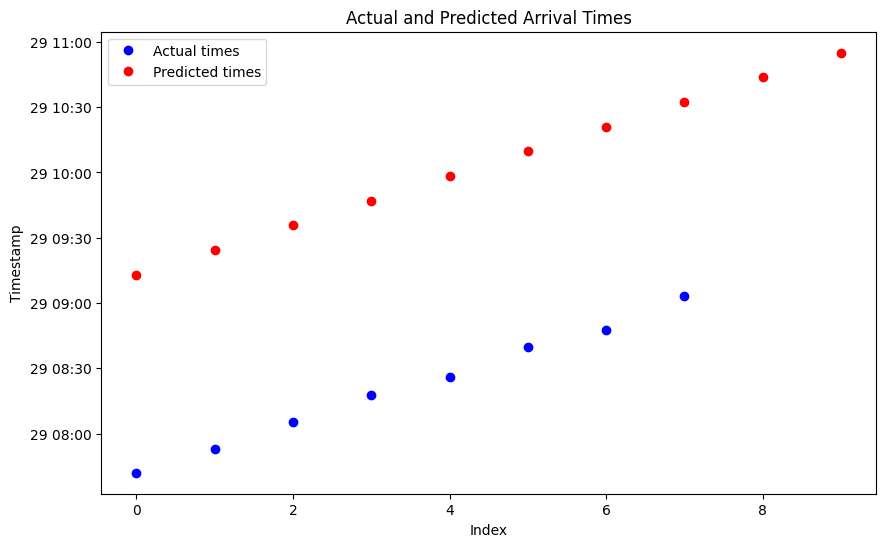

In [ ]:
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# List of provided expected arrival times
timestamps = [
    '2024-07-29 07:42:01',
    '2024-07-29 07:53:06',
    '2024-07-29 08:05:31',
    '2024-07-29 08:17:52',
    '2024-07-29 08:26:07',
    '2024-07-29 08:39:40',
    '2024-07-29 08:47:32',
    '2024-07-29 09:03:24'
]

# Convert strings to datetime objects
timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

# Convert datetime objects to timestamps (seconds since epoch)
timestamps_seconds = [(ts - datetime(1970, 1, 1)).total_seconds() for ts in timestamps]

# Prepare data for linear regression
X = np.array(range(len(timestamps))).reshape(-1, 1)  # Time index
y = np.array(timestamps_seconds)  # Corresponding timestamps in seconds

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict timestamps two hours beyond the last entry
num_predictions = 10
last_index = len(timestamps) - 1
future_indices = np.arange(last_index + 1, last_index + 1 + num_predictions).reshape(-1, 1)
future_seconds = model.predict(future_indices)

# Convert predicted seconds back to datetime
future_times = [datetime(1970, 1, 1) + timedelta(seconds=ts) for ts in future_seconds]

# Print the results
print(f"Predicted timestamps (using linear regression):")
for ts in future_times:
    print(ts.strftime('%Y-%m-%d %H:%M:%S'))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(timestamps, 'bo', label='Actual times')
plt.plot(future_times, 'ro', label='Predicted times')
plt.xlabel('Index')
plt.ylabel('Timestamp')
plt.title('Actual and Predicted Arrival Times')
plt.legend()
plt.show()


Predicted timestamps (using linear regression):
2024-07-29 09:12:55
2024-07-29 09:24:16
2024-07-29 09:35:36
2024-07-29 09:46:57
2024-07-29 09:58:17
2024-07-29 10:09:37
2024-07-29 10:20:58
2024-07-29 10:32:18
2024-07-29 10:43:39
2024-07-29 10:54:59
2024-07-29 11:06:19


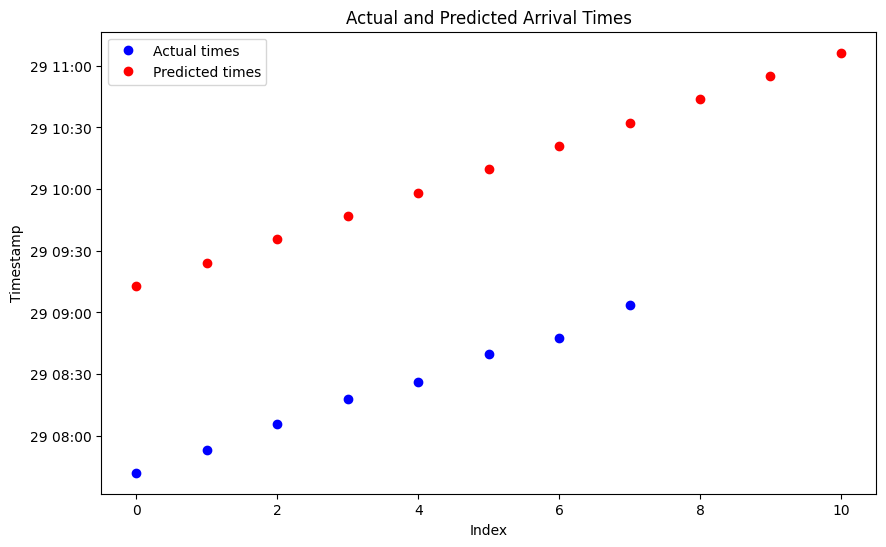

In [ ]:
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# List of provided expected arrival times
timestamps = [
    '2024-07-29 07:42:01',
    '2024-07-29 07:53:06',
    '2024-07-29 08:05:31',
    '2024-07-29 08:17:52',
    '2024-07-29 08:26:07',
    '2024-07-29 08:39:40',
    '2024-07-29 08:47:32',
    '2024-07-29 09:03:24'
]

# Convert strings to datetime objects
timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

# Convert datetime objects to timestamps (seconds since epoch)
timestamps_seconds = [(ts - datetime(1970, 1, 1)).total_seconds() for ts in timestamps]

# Prepare data for linear regression
X = np.array(range(len(timestamps))).reshape(-1, 1)  # Time index
y = np.array(timestamps_seconds)  # Corresponding timestamps in seconds

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Calculate average time interval
intervals = np.diff(timestamps_seconds)
average_interval = np.mean(intervals)  # Average interval in seconds

# Calculate the total number of future predictions needed to cover 2 hours
duration_seconds = 2 * 3600  # Two hours in seconds
num_predictions = int(np.ceil(duration_seconds / average_interval))  # Number of future points

# Predict future timestamps
last_index = len(timestamps) - 1
future_indices = np.arange(last_index + 1, last_index + 1 + num_predictions).reshape(-1, 1)
future_seconds = model.predict(future_indices)

# Convert predicted seconds back to datetime
future_times = [datetime(1970, 1, 1) + timedelta(seconds=ts) for ts in future_seconds]

# Print the results
print(f"Predicted timestamps (using linear regression):")
for ts in future_times:
    print(ts.strftime('%Y-%m-%d %H:%M:%S'))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(timestamps, 'bo', label='Actual times')
plt.plot(future_times, 'ro', label='Predicted times')
plt.xlabel('Index')
plt.ylabel('Timestamp')
plt.title('Actual and Predicted Arrival Times')
plt.legend()
plt.show()


Random Forest

Predicted timestamps (using Random Forest):
2024-07-29 09:17:03
2024-07-29 09:30:42
2024-07-29 09:44:21
2024-07-29 09:58:01
2024-07-29 10:11:40
2024-07-29 10:25:19
2024-07-29 10:38:59
2024-07-29 10:52:38
2024-07-29 11:06:17
2024-07-29 11:19:57


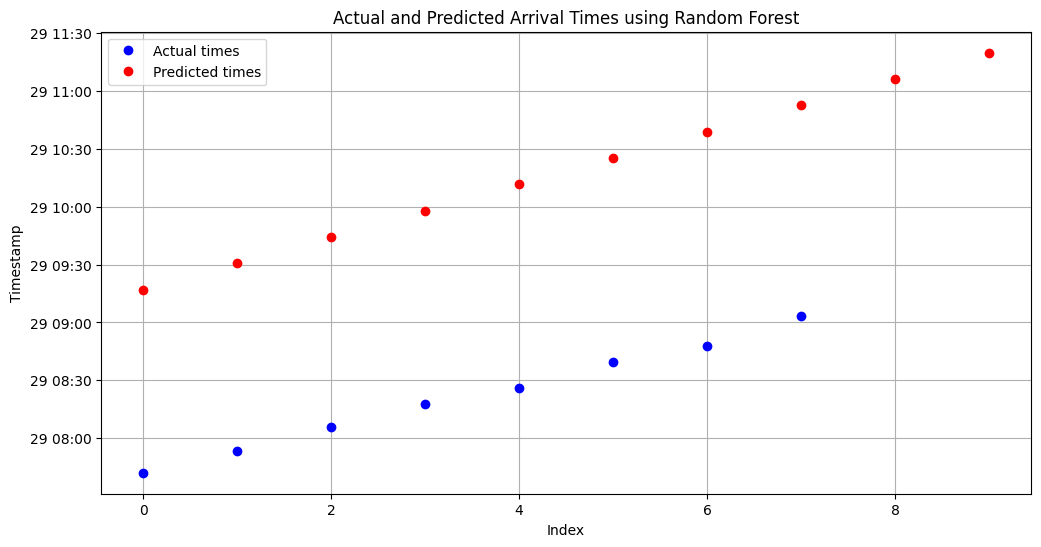

In [ ]:
import numpy as np
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# List of provided expected arrival times
timestamps = [
    '2024-07-29 07:42:01',
    '2024-07-29 07:53:06',
    '2024-07-29 08:05:31',
    '2024-07-29 08:17:52',
    '2024-07-29 08:26:07',
    '2024-07-29 08:39:40',
    '2024-07-29 08:47:32',
    '2024-07-29 09:03:24'
]

# Convert strings to datetime objects
timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

# Convert datetime objects to timestamps (seconds since epoch)
timestamps_seconds = [(ts - datetime(1970, 1, 1)).total_seconds() for ts in timestamps]

# Calculate time intervals between timestamps
intervals = np.diff(timestamps_seconds, prepend=timestamps_seconds[0])

# Create features: index and intervals
def create_features(intervals):
    indices = np.arange(len(intervals)).reshape(-1, 1)
    return indices

# Prepare data for Random Forest model
X = create_features(intervals)
y = np.array(intervals)

# Create and fit the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

# Predict time intervals for the next two hours after the last entry
num_predictions = 10
last_index = len(intervals) - 1
future_indices = np.arange(last_index + 1, last_index + 1 + num_predictions).reshape(-1, 1)

# Predict future intervals
future_intervals = model.predict(future_indices)

# Compute the future timestamps
future_timestamps_seconds = np.cumsum(np.concatenate([[timestamps_seconds[-1]], future_intervals]))
future_times = [datetime(1970, 1, 1) + timedelta(seconds=ts) for ts in future_timestamps_seconds[1:]]

# Print the results
print(f"Predicted timestamps (using Random Forest):")
for ts in future_times:
    print(ts.strftime('%Y-%m-%d %H:%M:%S'))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(timestamps, 'bo', label='Actual times')
plt.plot(future_times, 'ro', label='Predicted times')
plt.xlabel('Index')
plt.ylabel('Timestamp')
plt.title('Actual and Predicted Arrival Times using Random Forest')
plt.legend()
plt.grid(True)
plt.show()


Predicted timestamps (using Random Forest) for the next two hours:
2024-07-29 09:17:03
2024-07-29 09:30:42
2024-07-29 09:44:21
2024-07-29 09:58:01
2024-07-29 10:11:40
2024-07-29 10:25:19
2024-07-29 10:38:59
2024-07-29 10:52:38


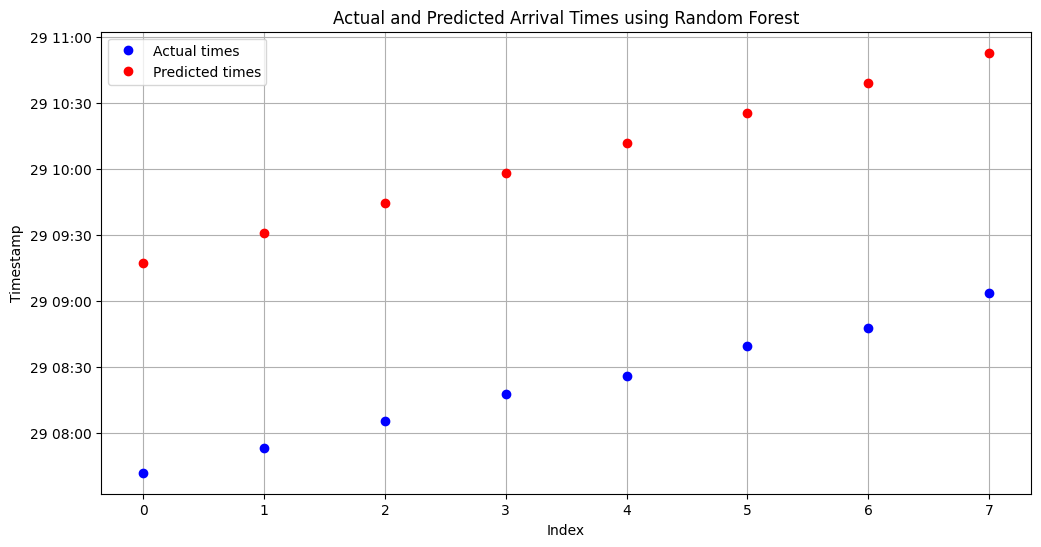

In [ ]:
import numpy as np
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# List of provided expected arrival times
timestamps = [
    '2024-07-29 07:42:01',
    '2024-07-29 07:53:06',
    '2024-07-29 08:05:31',
    '2024-07-29 08:17:52',
    '2024-07-29 08:26:07',
    '2024-07-29 08:39:40',
    '2024-07-29 08:47:32',
    '2024-07-29 09:03:24'
]

# Convert strings to datetime objects
timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamps]

# Convert datetime objects to timestamps (seconds since epoch)
timestamps_seconds = [(ts - datetime(1970, 1, 1)).total_seconds() for ts in timestamps]

# Calculate time intervals between timestamps
intervals = np.diff(timestamps_seconds, prepend=timestamps_seconds[0])

# Create features: index and intervals
def create_features(intervals):
    indices = np.arange(len(intervals)).reshape(-1, 1)
    return indices

# Prepare data for Random Forest model
X = create_features(intervals)
y = np.array(intervals)

# Create and fit the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

# Calculate how many intervals are needed to cover 2 hours (7200 seconds)
last_interval = intervals[-1]
average_interval = np.mean(intervals[1:])  # Use the average interval for predictions
num_intervals = int(np.ceil(7200 / average_interval))  # Number of intervals needed

# Predict future intervals
last_index = len(intervals) - 1
future_indices = np.arange(last_index + 1, last_index + 1 + num_intervals).reshape(-1, 1)
future_intervals = model.predict(future_indices)

# Compute the future timestamps
future_timestamps_seconds = np.cumsum(np.concatenate([[timestamps_seconds[-1]], future_intervals]))
future_times = [datetime(1970, 1, 1) + timedelta(seconds=ts) for ts in future_timestamps_seconds[1:]]

# Filter timestamps to only those within the next 2 hours from the last timestamp
last_timestamp = timestamps[-1]
end_time = last_timestamp + timedelta(hours=2)
future_times = [ts for ts in future_times if ts <= end_time]

# Print the results
print(f"Predicted timestamps (using Random Forest) for the next two hours:")
for ts in future_times:
    print(ts.strftime('%Y-%m-%d %H:%M:%S'))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(timestamps, 'bo', label='Actual times')
plt.plot(future_times, 'ro', label='Predicted times')
plt.xlabel('Index')
plt.ylabel('Timestamp')
plt.title('Actual and Predicted Arrival Times using Random Forest')
plt.legend()
plt.grid(True)
plt.show()
